# Прогнозирование оттока телеком компании

По заказу оператора связи на основе данных клиентских данных необходимо разработать модель, которая будет предсказывать уход клиента. 

## Загрузка библиотек

In [1]:
# Импорт и установка библиотек
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

!pip3 install phik
from phik import phik_matrix

!pip3 install --upgrade scikit-learn
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, roc_curve, auc, confusion_matrix, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import os;

## Предобработка и исследовательский анализ данных

In [2]:
# Функция первичного просмотра общей информации о df и удалению полных дубликатов
# на входе датасет, на выходе визуализация общих данных, 
# удаление полных дубликатов и вывод информации о датасете без полных дубликатов
def df_viewer(df):
    display(df.sample(5))
    display(df.info())
    display(df.describe())
    print()
    print('no duplicates')
    print()
    df =df.drop_duplicates()
    display(df.info())

# Функция для просмотра общей информации об object series и построении pieplot
# На входе категориальный столбец датасета, на выходе вывод общей информации и построение pie plot
def pie_plotter(series):
    # Вывод названия и общей информации о столбике
    print()
    print(series.name)
    display(series.describe())
    
    # Построение pieplot
    plt.figure(figsize=(16, 6))  
    series.value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(series.name)
    plt.show()
    
# Функция для просмотра общей информации об numeric series и построении hist и boxplot 
# На входе численный столбец датасета, на выходе вывод общей информации и построение hist и boxplot
def hist_plotter(series):
    # Вывод названия и общей информации о столбике
    print()
    print(series.name)
    display(series.describe())
    
    # Построение hist
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(series.dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Построение boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(series.dropna())
    plt.title('Boxplot')
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()

# Функция для построения  pieplot
# На входе категориальный столбец датасета, на выходе построение pie plot
def pie_plotter_pair(series): 
    series.value_counts().plot(kind='pie', autopct='%1.1f%%')

In [3]:
# Загрузка и просмотр общей информации о contract

try:
    path = '/datasets/contract_new.csv'
    contract = pd.read_csv(path)

except FileNotFoundError:
    current_directory = os.getcwd()
    contract = pd.read_csv(current_directory + path)

df_viewer(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3326,7657-DYEPJ,2016-11-01,2018-08-01,One year,Yes,Credit card (automatic),70.15,1473.15
5709,5602-BVFMK,2019-02-01,No,One year,No,Mailed check,19.30,240.86
583,1423-BMPBQ,2020-01-01,No,Month-to-month,Yes,Mailed check,19.00,19.19
3547,1568-BEKZM,2014-04-01,No,Two year,No,Credit card (automatic),90.05,6555.64
5151,5562-YJQGT,2019-12-01,No,Month-to-month,No,Credit card (automatic),20.35,40.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Датасет contract не содержит NaN значений и полных дубликатов. Total charges имеет неверный тип object - необходимо исправить.

In [4]:
# Вывод общей информации о столбце
contract['customerID'].describe()

count           7043
unique          7043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object

In [5]:
# Вывод общей информации о столбце
contract['BeginDate'].describe()

count           7043
unique            77
top       2014-02-01
freq             366
Name: BeginDate, dtype: object

In [6]:
# Вывод общей информации о столбце
contract['EndDate'].describe()

count     7043
unique      67
top         No
freq      5942
Name: EndDate, dtype: object

In [7]:
# Создание столбца Target на основе даты окончания пользования услугами EndDate
contract['Target'] = np.where(contract['EndDate'] == 'No', 'No', 'Yes')

# Вывод общей информации о столбце
display(contract['Target'])
display(contract['Target'].describe())

0       No
1       No
2       No
3       No
4       No
        ..
7038    No
7039    No
7040    No
7041    No
7042    No
Name: Target, Length: 7043, dtype: object

count     7043
unique       2
top         No
freq      5942
Name: Target, dtype: object

In [8]:
# Приведение столбца TotalCharges к типу float
contract['TotalCharges'] = contract['TotalCharges'].str.replace('[^\d.]', '', regex=True).str.strip()
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

# Вывод строк с пропусками в TotalCharges
display(contract[contract['TotalCharges'].isna()])

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2r/zfmtb66x3rs14ctpbj7lhdt40000gp/T/ipykernel_19745/1332979283.py:2: SyntaxWarning: invalid escape sequence '\d'
  contract['TotalCharges'] = contract['TotalCharges'].str.replace('[^\d.]', '', regex=True).str.strip()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,No


In [9]:
# Все клиенты с пропущенными TotalCharges имеют нулевыми расходами, т.к. подключились только сегодня. 
# Заменяем пропуски TotalCharges на нули
contract['TotalCharges'].fillna(0, inplace=True)

print('Количество пропусков в столбце TotalCharges:', contract['TotalCharges'].isna().sum())

Количество пропусков в столбце TotalCharges: 0


/var/folders/2r/zfmtb66x3rs14ctpbj7lhdt40000gp/T/ipykernel_19745/11084234.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract['TotalCharges'].fillna(0, inplace=True)


In [10]:
# Вывод общей информации о столбце
display(contract['TotalCharges'].describe())

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

Столбец содержал 11 нечисленных значений, столбец приведен к float формату и пропуски были заменены на нули, т.к. эти клиенты подключились сегодня и не имели расходов.

In [11]:
# Получим список категориальных столбцов для построения pieplot
contract_object_columns = list(contract.drop(['customerID', 'BeginDate', 'EndDate'], axis = 1).select_dtypes(include=['object']).columns)

# Получим список численных столбцов для построения hist и boxplot
contract_numeric_columns = list(contract.select_dtypes(include=['number']).columns)


Type


count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Type, dtype: object

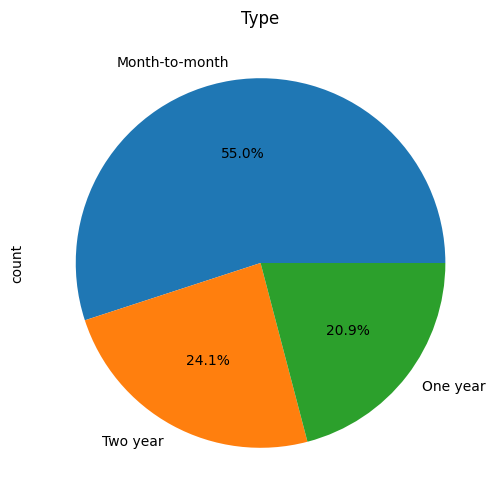


PaperlessBilling


count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object

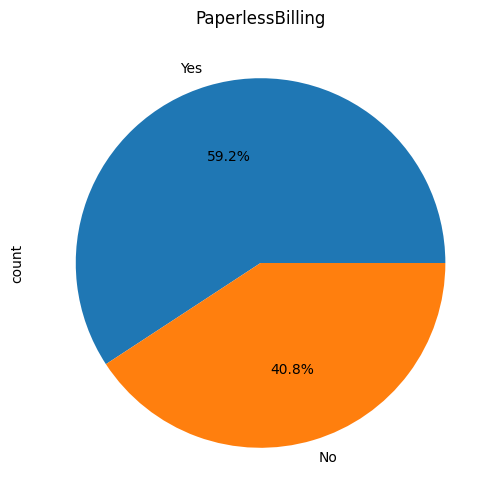


PaymentMethod


count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: PaymentMethod, dtype: object

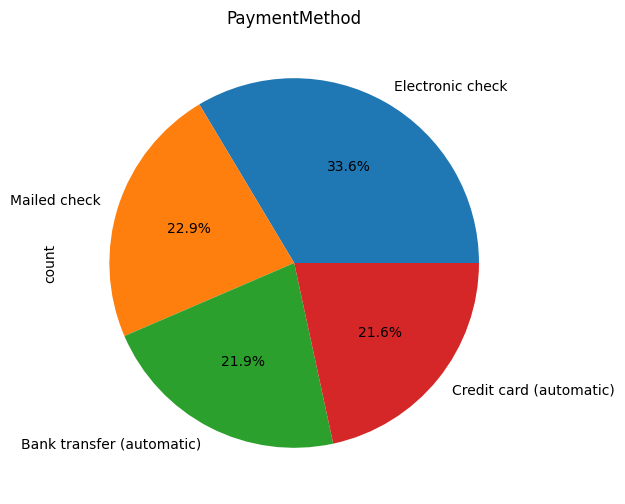


Target


count     7043
unique       2
top         No
freq      5942
Name: Target, dtype: object

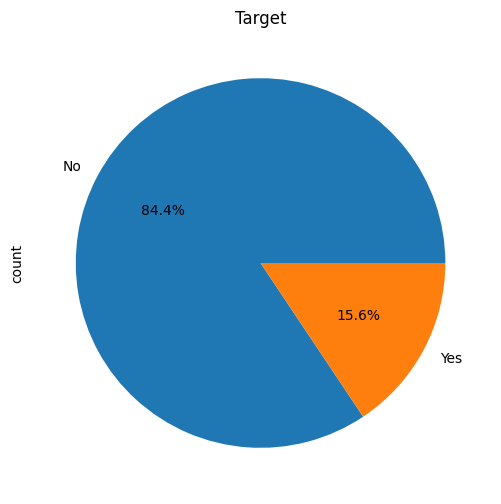

In [12]:
# Визуализируем object данные 
for column in contract_object_columns:
    pie_plotter(contract[column])

Построены pieplot диаграммы столбцов датасета contract, данные выглядят адекватными:
- чуть больше половины пользователей имеют помесячную оплату, четверть имеет годичный контракт и четверть двехгодичный,
- больше половины пользователей отказываются от бумажных чеков, 
- способ оплаты распределен примерно поровну между всеми типами с небольшим преобладанием электронных платежей
- большинство пользователей (84%) являются текущими, отток согласно датасету составил 16%, что говорит о некритичном дисбалансе классов. 


MonthlyCharges


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

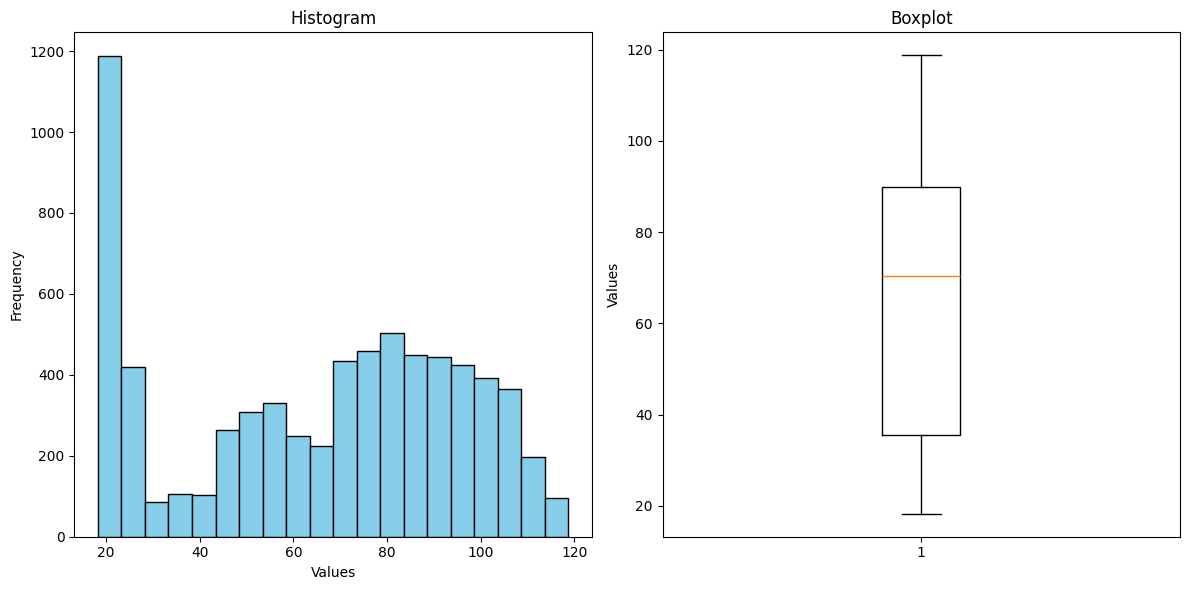


TotalCharges


count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

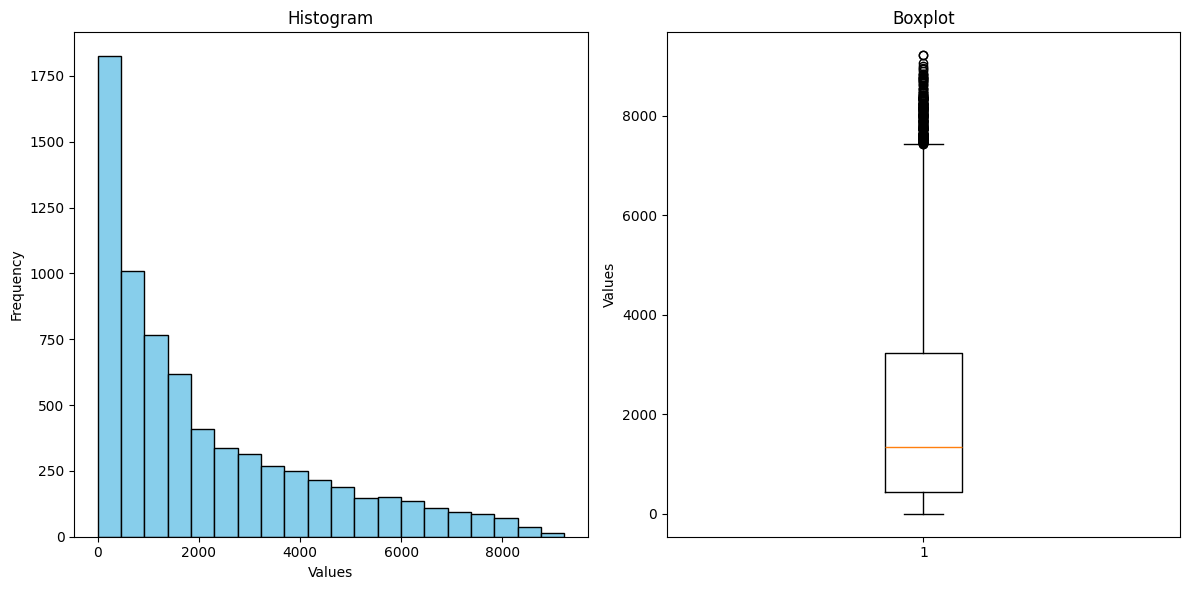

In [13]:
# Визуализируем float данные 
for column in contract_numeric_columns:
    hist_plotter(contract[column])

Построены распределения данных численных столбцов датасета contract. Численные признаки ведут себя адекватно - сравнительно большое количество пользователей имеют минимальные месячные затраты и малые общие затраты. Присутствует некоторое количество выбросов с аномально большими общими затратами. 

In [14]:
# Загрузка и просмотр общей информации о personal

try:
    path = '/datasets/personal_new.csv'
    personal = pd.read_csv(path)

except FileNotFoundError:
    current_directory = os.getcwd()
    personal = pd.read_csv(current_directory + path)

df_viewer(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
1692,1696-MZVAU,Male,0,Yes,Yes
1339,3838-OZURD,Male,0,Yes,No
6990,0376-OIWME,Male,0,Yes,No
5195,1676-MQAOA,Male,0,No,No
3427,9919-KNPOO,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [15]:
# Замена численных значений на строковые для единообразия и приведения столбца к object
#personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Приведения столбца к object
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype(str)

# Вывод общей информации о столбце
personal['SeniorCitizen'].describe()

count     7043
unique       2
top          0
freq      5901
Name: SeniorCitizen, dtype: object

In [16]:
# Вывод общей информации о столбце
personal['customerID'].describe()

count           7043
unique          7043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object

Датасет personal не содержит NaN значений и полных дубликатов. Исправил значения и тип столбца SeniorCitizen на категории. 

In [17]:
# Получим список столбцов для построения pieplot
personal_object_columns = list(personal.drop(['customerID'], axis = 1).select_dtypes(include=['object']).columns)


gender


count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

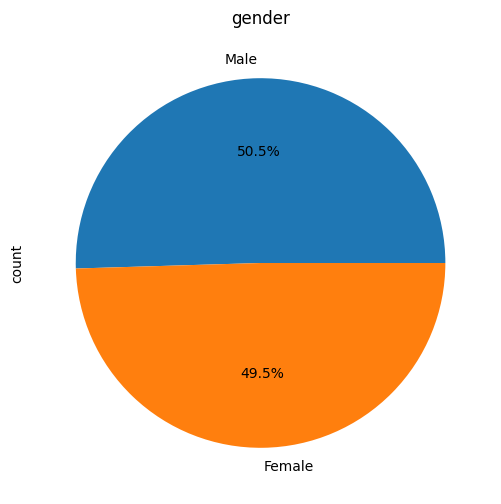


SeniorCitizen


count     7043
unique       2
top          0
freq      5901
Name: SeniorCitizen, dtype: object

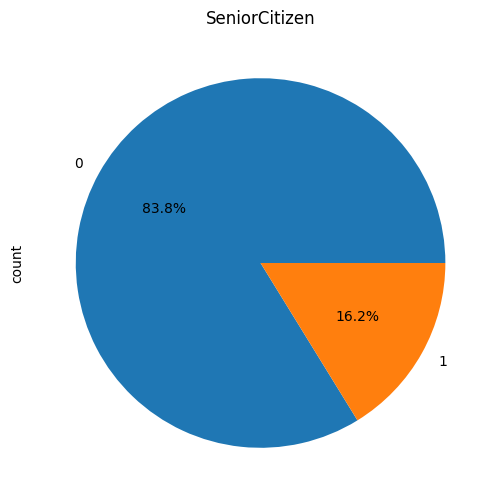


Partner


count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object

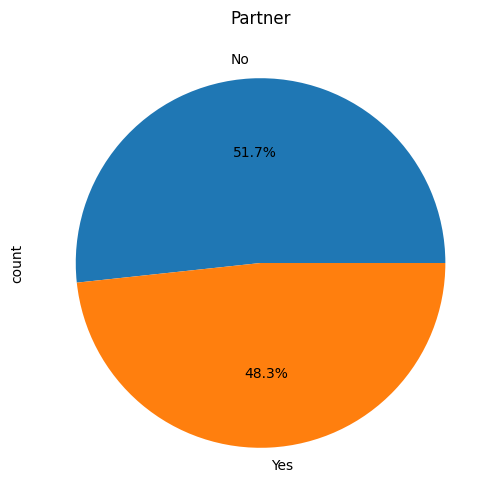


Dependents


count     7043
unique       2
top         No
freq      4933
Name: Dependents, dtype: object

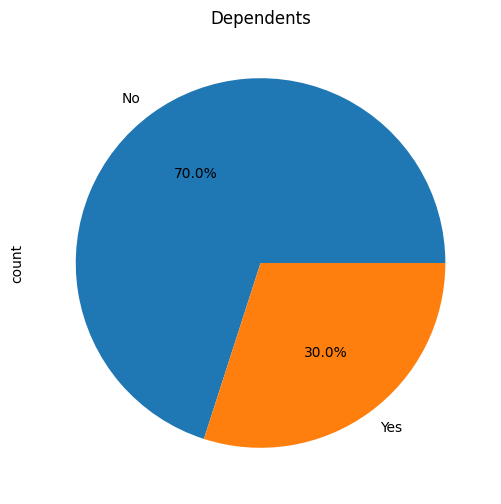

In [18]:
# Визуализируем object данные 
for column in personal_object_columns:
    pie_plotter(personal[column])

Построены pieplot диаграммы столбцов датасета personal, данные выглядят адекватными:
- пользователи делятся примерно поровну на мужчин и женщин, 
- большинство пользователей не достигло пенсионного возраста, 
- половина пользователей не состоят в браке,
- 30% пользователей с детьми.

In [19]:
# Загрузка и просмотр общей информации о internet

try:
    path = '/datasets/internet_new.csv'
    internet = pd.read_csv(path)

except FileNotFoundError:
    current_directory = os.getcwd()
    internet = pd.read_csv(current_directory + path)

df_viewer(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3257,5049-MUBWG,DSL,Yes,No,No,Yes,Yes,Yes
2257,6652-YFFJO,DSL,No,No,No,No,Yes,Yes
3532,9518-XXBXE,Fiber optic,Yes,No,No,No,No,No
4705,6595-YGXIT,Fiber optic,No,Yes,No,No,Yes,No
3207,2476-YGEFM,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [20]:
# Вывод общей информации о столбце
internet['customerID'].describe()

count           5517
unique          5517
top       7590-VHVEG
freq               1
Name: customerID, dtype: object

Датасет internet не содержит NaN значений и полных дубликатов. 

In [21]:
# Получим список столбцов для построения pieplot
internet_object_columns = list(internet.drop(['customerID'], axis = 1).select_dtypes(include=['object']).columns)


InternetService


count            5517
unique              2
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

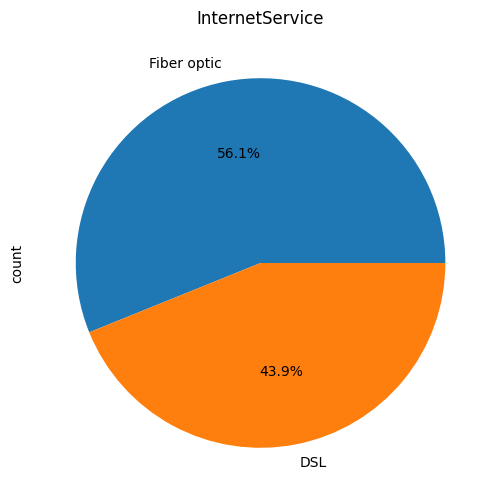


OnlineSecurity


count     5517
unique       2
top         No
freq      3498
Name: OnlineSecurity, dtype: object

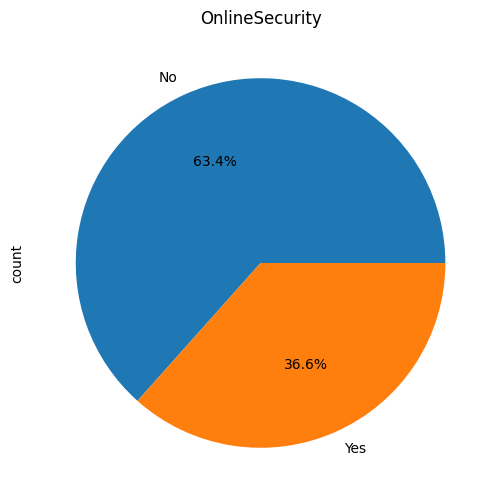


OnlineBackup


count     5517
unique       2
top         No
freq      3088
Name: OnlineBackup, dtype: object

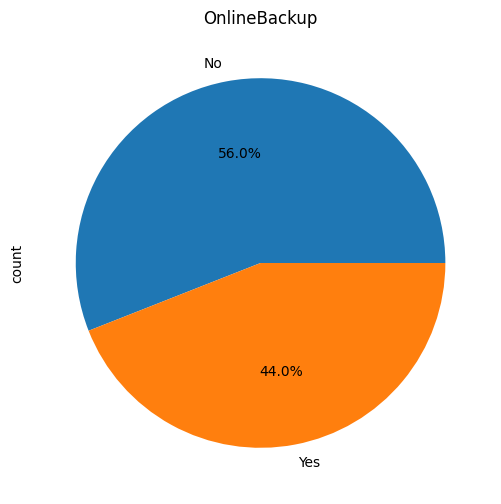


DeviceProtection


count     5517
unique       2
top         No
freq      3095
Name: DeviceProtection, dtype: object

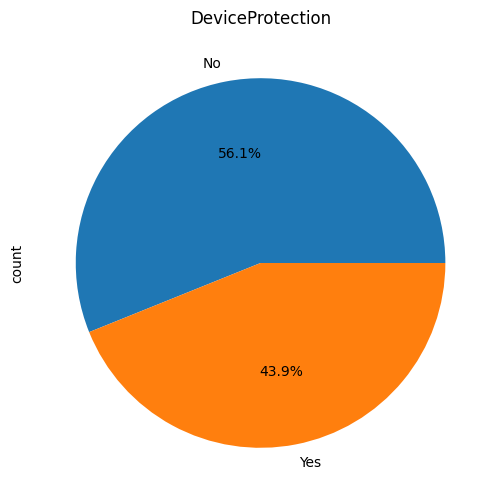


TechSupport


count     5517
unique       2
top         No
freq      3473
Name: TechSupport, dtype: object

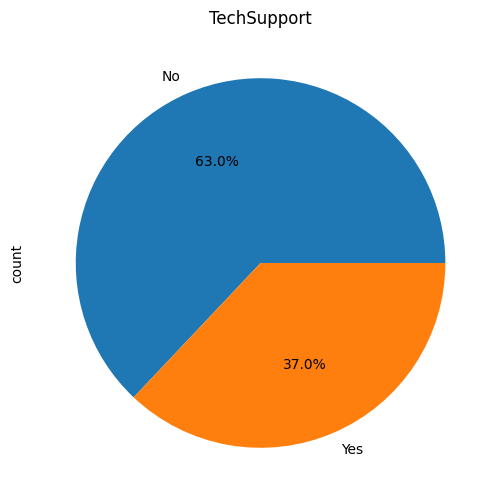


StreamingTV


count     5517
unique       2
top         No
freq      2810
Name: StreamingTV, dtype: object

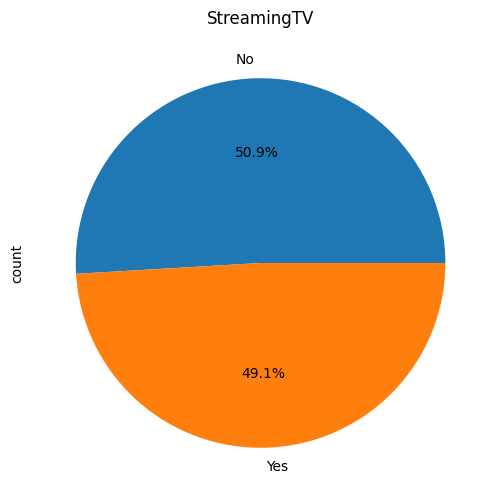


StreamingMovies


count     5517
unique       2
top         No
freq      2785
Name: StreamingMovies, dtype: object

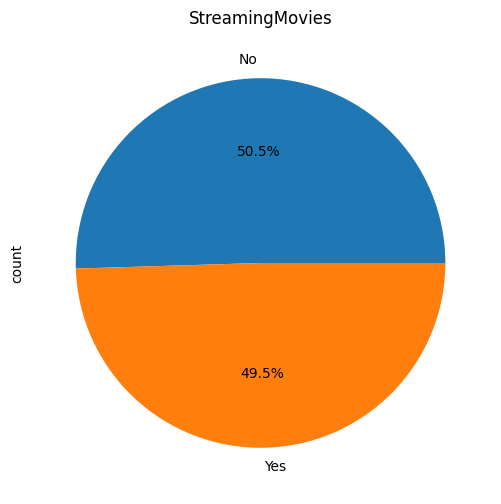

In [22]:
# Визуализируем object данные 
for column in internet_object_columns:
    pie_plotter(internet[column])

Построены pieplot диаграммы столбцов датасета internet, данные выглядят адекватными:
- чуть больше половины пользователей имеют оптико-волоконную линию, 
- треть пользователей пользуются услугой по блокировке опасных сайтов,
- чуть меньше половины пользователей пользуются облачным хранилищем файлов для резервного копирования данных,
- чуть меньше половины пользователей пользуются антивирусом,
- треть пользователей пользуются услугой выделенная линия технической поддержки,
- у половины пользователей стриминговое телевидение, 
- у половины пользователей каталог фильмов. 

In [23]:
# Загрузка и просмотр общей информации о phone

try:
    path = '/datasets/phone_new.csv'
    phone = pd.read_csv(path)

except FileNotFoundError:
    current_directory = os.getcwd()
    phone = pd.read_csv(current_directory + path)

df_viewer(phone)

,customerID,MultipleLines
4359,2284-VFLKH,No
5249,1818-ESQMW,No
3594,4495-LHSSK,Yes
3954,7998-ZLXWN,No
5601,0201-MIBOL,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [24]:
# Вывод общей информации о столбце
phone['customerID'].describe()

count           6361
unique          6361
top       5575-GNVDE
freq               1
Name: customerID, dtype: object

Датасет phone не содержит NaN значений и полных дубликатов. 

In [25]:
# Получим список столбцов для построения pieplot
phone_object_columns = list(phone.drop(['customerID'], axis = 1).select_dtypes(include=['object']).columns)


MultipleLines


count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object

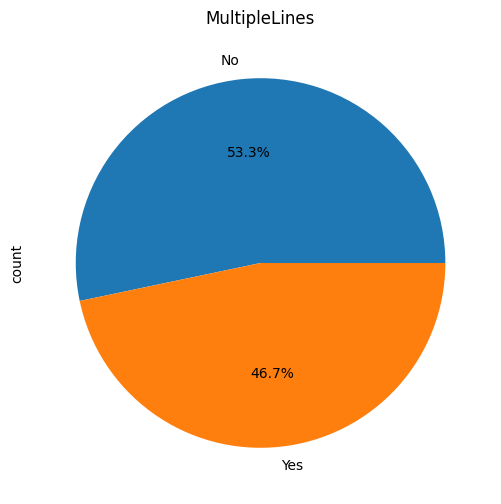

In [26]:
# Визуализируем object данные 
for column in phone_object_columns:
    pie_plotter(phone[column])

Построены pieplot диаграммы столбца MultipleLines датасета phone, данные выглядят адекватными:
- чуть меньше половины пользователей имеют подключение телефона к нескольким линиям одновременно.

## Подготовка и анализ итоговой таблицы

### Создание итоговой таблицы и общая информация о ней

In [27]:
# Сконвертируем BeginDate и EndDate во временные метки
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

# Добавим столбец Duration - длительность контракта 
contract['Duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

# В случае продолжающегося контракта, внесем длительность на сегодняшний день
no_mask = contract['EndDate'].isnull()
contract.loc[no_mask, 'EndDate'] = pd.to_datetime('2020-02-01')
contract.loc[no_mask, 'Duration'] = (contract.loc[no_mask, 'EndDate'] - contract.loc[no_mask, 'BeginDate']).dt.days

/var/folders/2r/zfmtb66x3rs14ctpbj7lhdt40000gp/T/ipykernel_19745/1539076468.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')


In [28]:
# Выполняем outer merge по столбцу 'customerID'
data = pd.merge(contract, personal, on='customerID', how='outer')
data = pd.merge(data, internet, on='customerID', how='outer')
data = pd.merge(data, phone, on='customerID', how='outer')

data.set_index('customerID', inplace=True)

# Выводим данные о смерженной таблице data
df_viewer(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
0685-MLYYM,2019-11-01,2020-02-01,Month-to-month,No,Electronic check,70.75,212.25,No,92.0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
5697-GOMBF,2017-10-01,2020-02-01,Month-to-month,Yes,Electronic check,35.90,1005.20,No,853.0,Female,...,Yes,Yes,DSL,No,No,No,No,Yes,No,NaN
3748-FVMZZ,2019-10-01,2020-02-01,Month-to-month,Yes,Electronic check,40.05,176.22,No,123.0,Male,...,No,No,DSL,No,No,No,Yes,No,Yes,NaN
2545-EBUPK,2019-12-01,2020-02-01,Month-to-month,Yes,Electronic check,84.05,179.87,No,62.0,Female,...,No,No,Fiber optic,No,No,No,No,No,Yes,Yes
6877-TJMBR,2019-10-01,2020-02-01,Month-to-month,Yes,Electronic check,84.80,339.20,No,123.0,Male,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   object        
 8   Duration          7043 non-null   float64       
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

None

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Duration
count,7043,7043,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253184,64.761692,2115.312885,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,2314.000000
std,NaN,NaN,30.090047,2112.742814,683.130510



no duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           7039 non-null   datetime64[ns]
 2   Type              7039 non-null   object        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   object        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   Target            7039 non-null   object        
 8   Duration          7039 non-null   float64       
 9   gender            7039 non-null   object        
 10  SeniorCitizen     7039 non-null   object        
 11  Partner           7039 non-null   object        
 12  Dependents        7039 non-null   object        
 13  InternetService   5516 non-null   object        
 14

None

Смерженный датасет data содержит NaN значения, которые возникли во время мерджа датасетов, т.к. не все пользователи пользуются всеми услугами. 

In [29]:
# Заменим возникшие NaN значения на Other
data.fillna('Other', inplace=True)
df_viewer(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
0064-SUDOG,2019-02-01,2020-02-01,Two year,No,Bank transfer (automatic),20.3,243.60,No,365.0,Female,...,Yes,Yes,Other,Other,Other,Other,Other,Other,Other,No
6859-QNXIQ,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),113.1,8957.52,No,2191.0,Female,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5161-XEUVX,2017-01-01,2020-02-01,Two year,No,Mailed check,94.3,3628.66,No,1126.0,Male,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,No,Yes
0867-MKZVY,2018-03-01,2020-02-01,Month-to-month,No,Electronic check,82.4,1933.10,No,702.0,Female,...,Yes,No,Fiber optic,Yes,No,No,No,No,No,Yes
3807-XHCJH,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,20.0,20.80,No,31.0,Female,...,Yes,Yes,Other,Other,Other,Other,Other,Other,Other,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   object        
 8   Duration          7043 non-null   float64       
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

None

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Duration
count,7043,7043,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253184,64.761692,2115.312885,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,2314.000000
std,NaN,NaN,30.090047,2112.742814,683.130510



no duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7039 non-null   datetime64[ns]
 1   EndDate           7039 non-null   datetime64[ns]
 2   Type              7039 non-null   object        
 3   PaperlessBilling  7039 non-null   object        
 4   PaymentMethod     7039 non-null   object        
 5   MonthlyCharges    7039 non-null   float64       
 6   TotalCharges      7039 non-null   float64       
 7   Target            7039 non-null   object        
 8   Duration          7039 non-null   float64       
 9   gender            7039 non-null   object        
 10  SeniorCitizen     7039 non-null   object        
 11  Partner           7039 non-null   object        
 12  Dependents        7039 non-null   object        
 13  InternetService   7039 non-null   object        
 14

None

### Анализ данных

In [30]:
# Получим список столбцов для построения pieplot
data_object_columns = list(data.drop(['BeginDate', 'EndDate'], axis = 1).select_dtypes(include=['object']).columns)

# Получим список численных столбцов для построения hist и boxplot
data_numeric_columns = list(data.select_dtypes(include=['number']).columns)


Type


count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Type, dtype: object

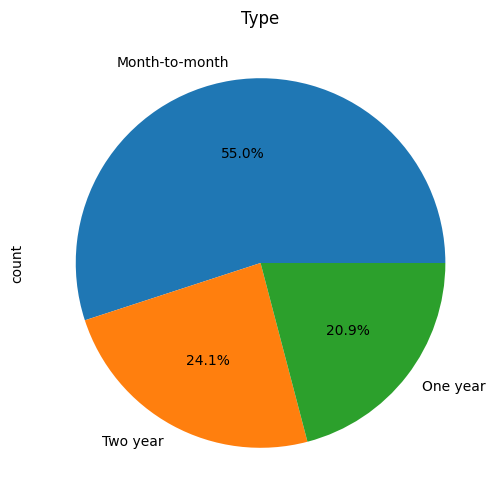


PaperlessBilling


count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object

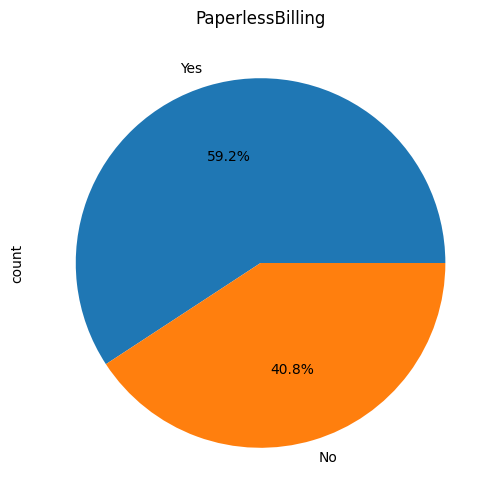


PaymentMethod


count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: PaymentMethod, dtype: object

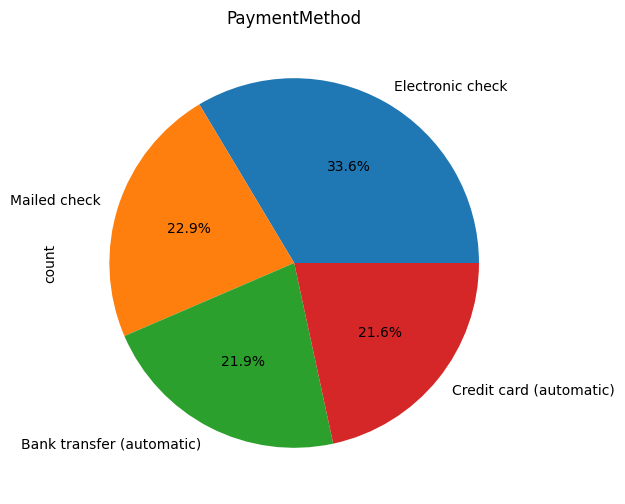


Target


count     7043
unique       2
top         No
freq      5942
Name: Target, dtype: object

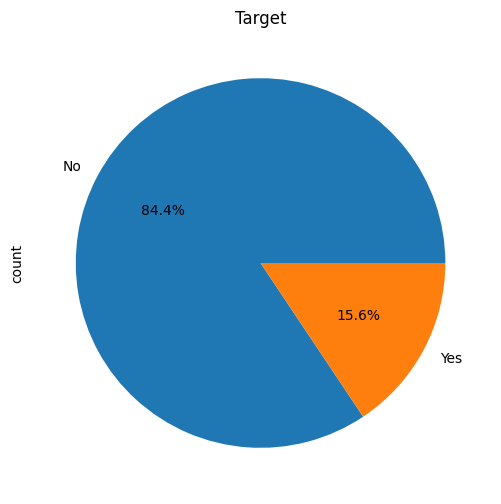


gender


count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

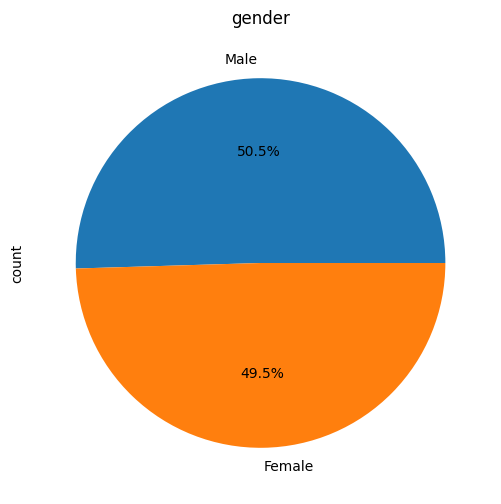


SeniorCitizen


count     7043
unique       2
top          0
freq      5901
Name: SeniorCitizen, dtype: object

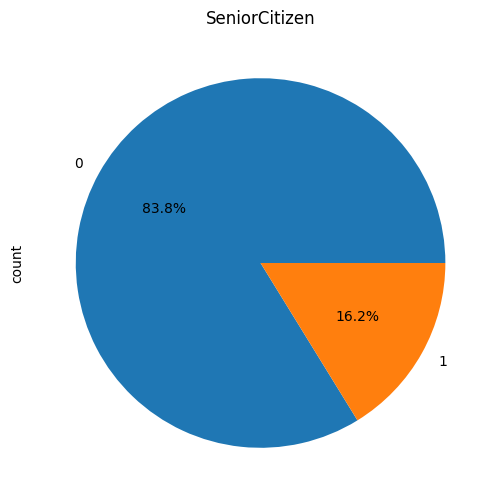


Partner


count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object

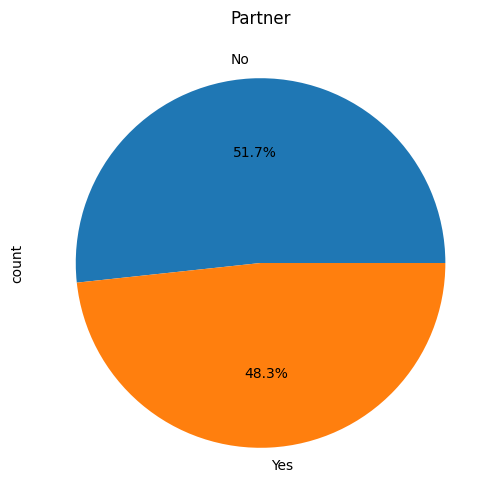


Dependents


count     7043
unique       2
top         No
freq      4933
Name: Dependents, dtype: object

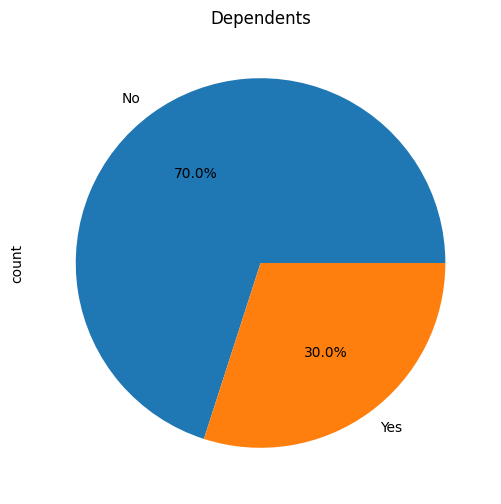


InternetService


count            7043
unique              3
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

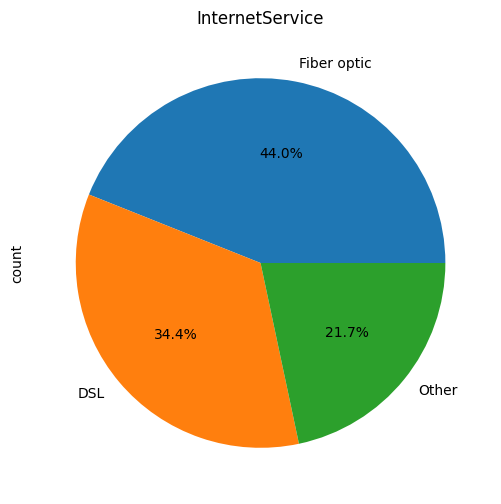


OnlineSecurity


count     7043
unique       3
top         No
freq      3498
Name: OnlineSecurity, dtype: object

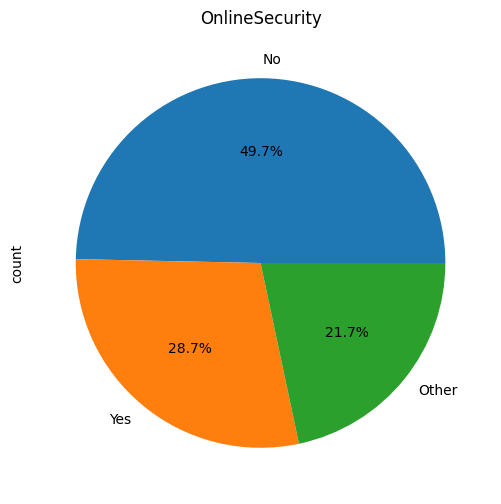


OnlineBackup


count     7043
unique       3
top         No
freq      3088
Name: OnlineBackup, dtype: object

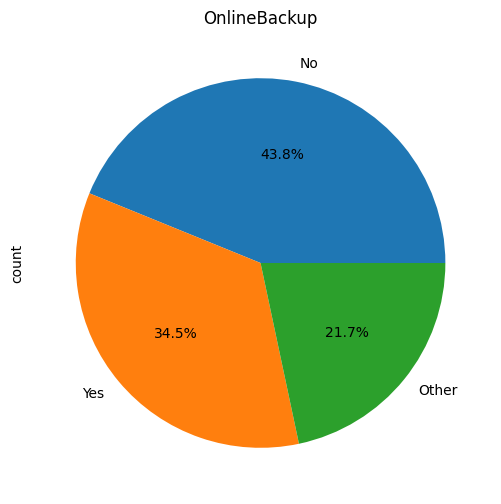


DeviceProtection


count     7043
unique       3
top         No
freq      3095
Name: DeviceProtection, dtype: object

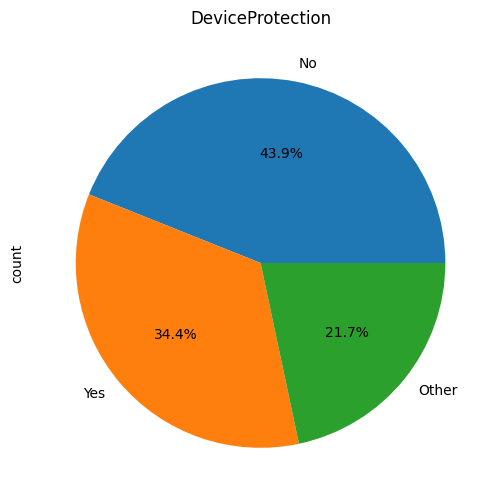


TechSupport


count     7043
unique       3
top         No
freq      3473
Name: TechSupport, dtype: object

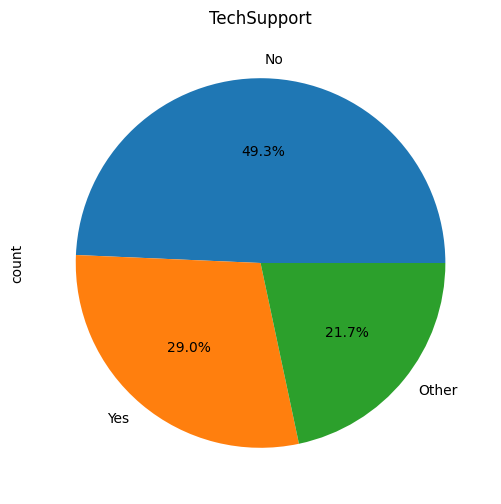


StreamingTV


count     7043
unique       3
top         No
freq      2810
Name: StreamingTV, dtype: object

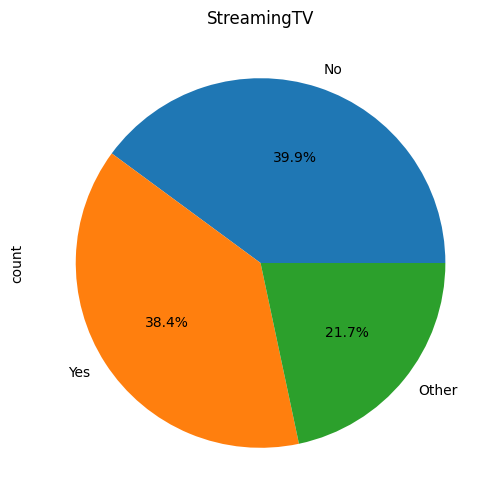


StreamingMovies


count     7043
unique       3
top         No
freq      2785
Name: StreamingMovies, dtype: object

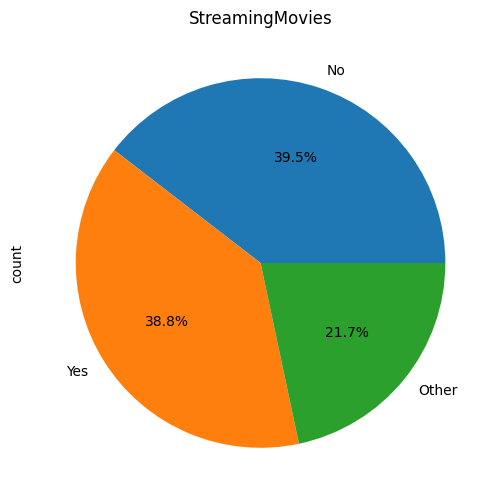


MultipleLines


count     7043
unique       3
top         No
freq      3390
Name: MultipleLines, dtype: object

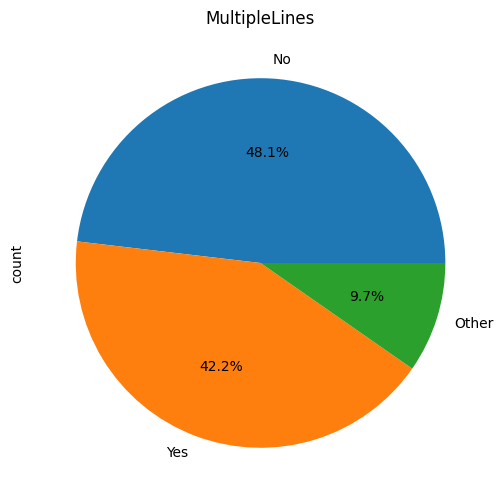

In [31]:
# Визуализируем object данные 
for column in data_object_columns:
    pie_plotter(data[column])


MonthlyCharges


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

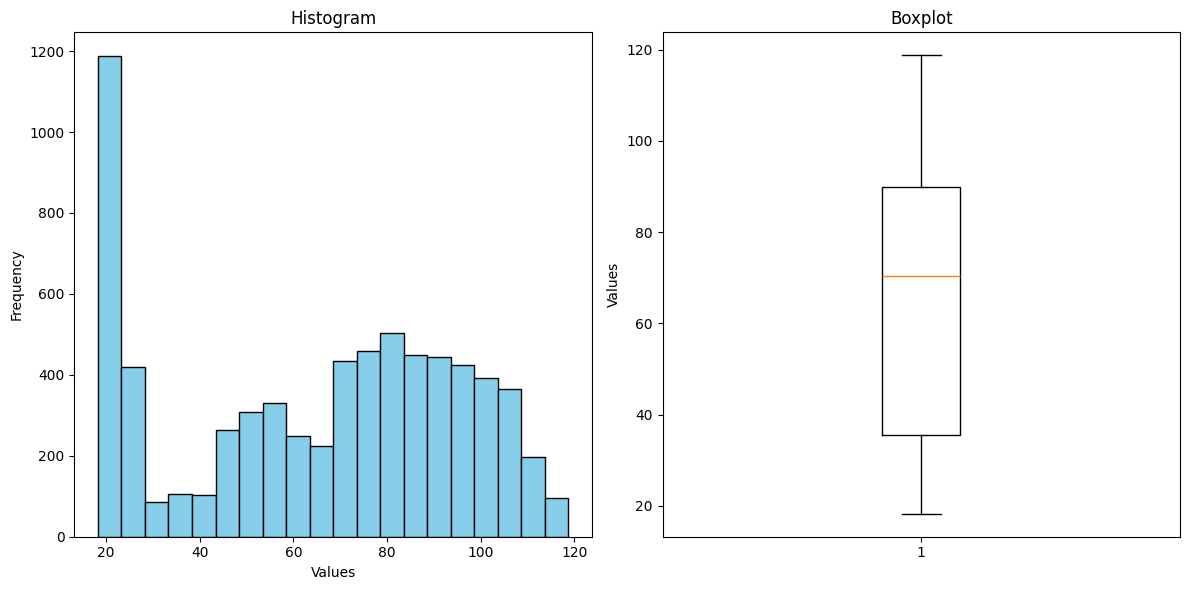


TotalCharges


count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

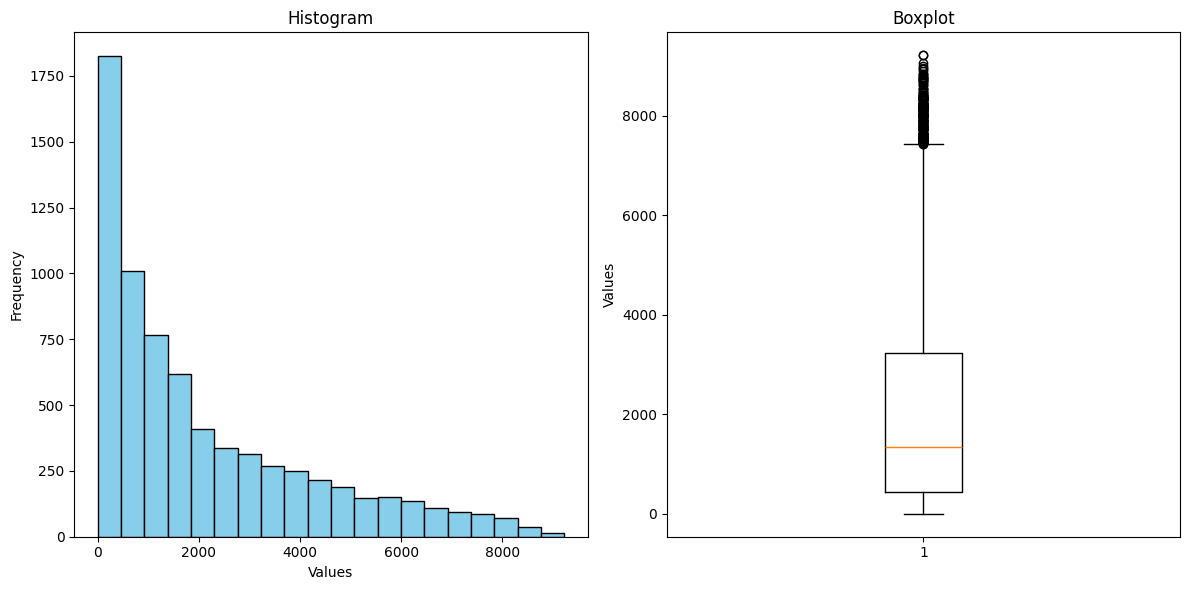


Duration


count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: Duration, dtype: float64

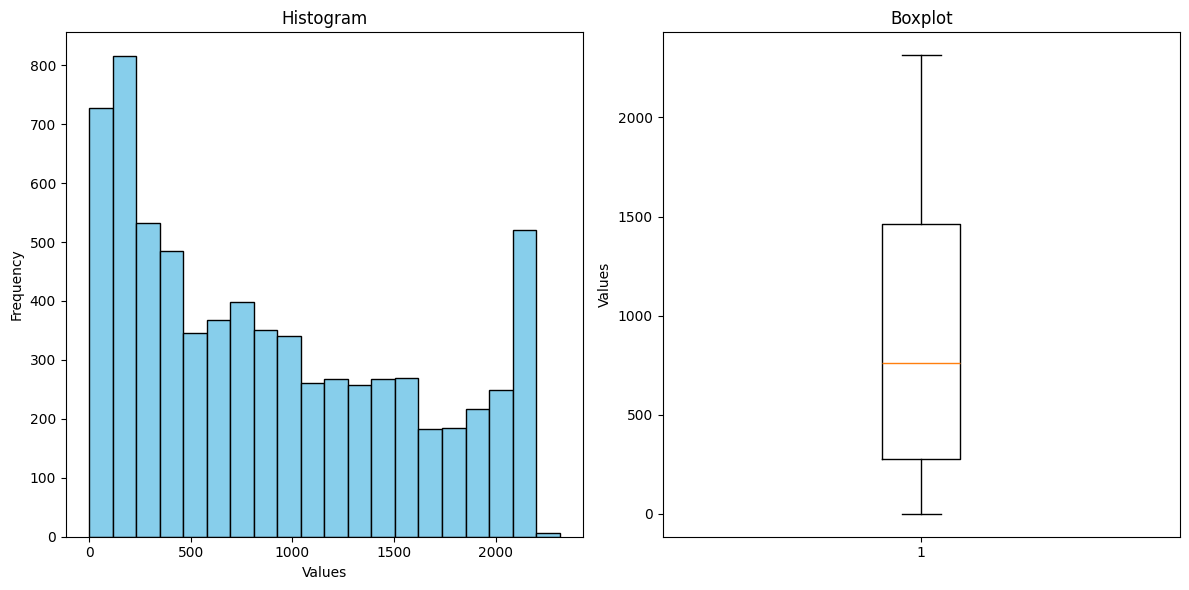

In [32]:
# Визуализируем float данные 
for column in data_numeric_columns:
    hist_plotter(data[column])

В распределениях после мерджа появились клиенты новой категории - без интернет-услуг или без телефонных услуг. 

Новый столбец Duration имеет два пика распределения, что говорит о том, что можно выделить высокую регулярность оттока пользователей в начале пользования и/или большой приток новых клиентов, а также то, что есть группа пользователей, которая очень долго пользуется услугами компании (уже несколько лет). 

### Анализ с разбивкой по Target

Type


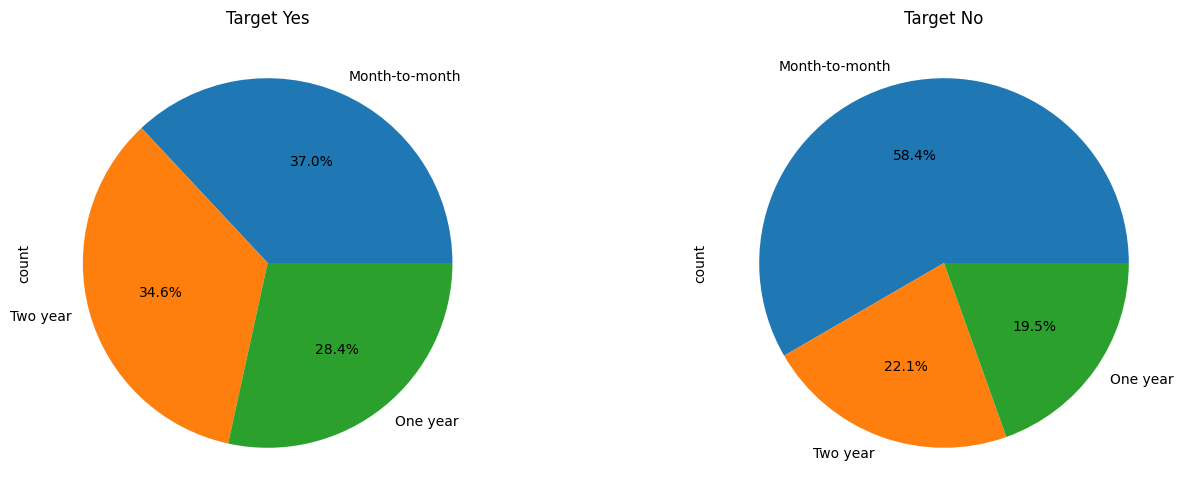

PaperlessBilling


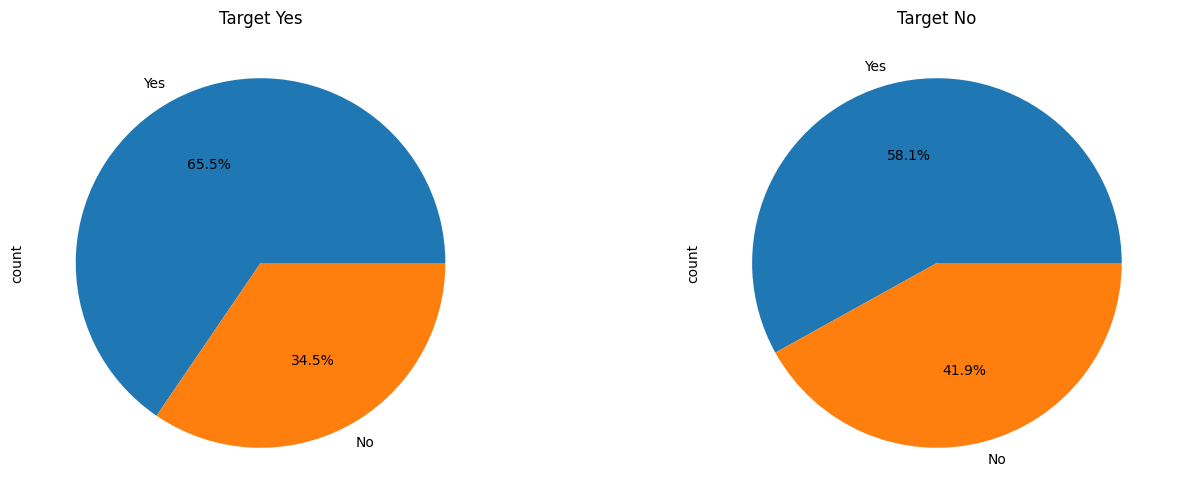

PaymentMethod


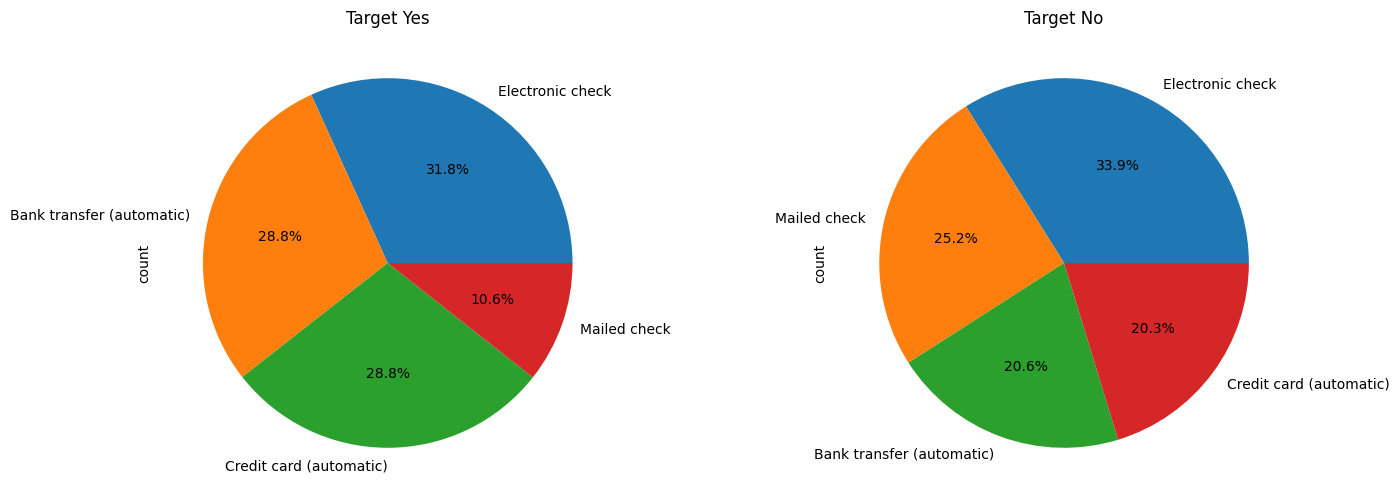

Target


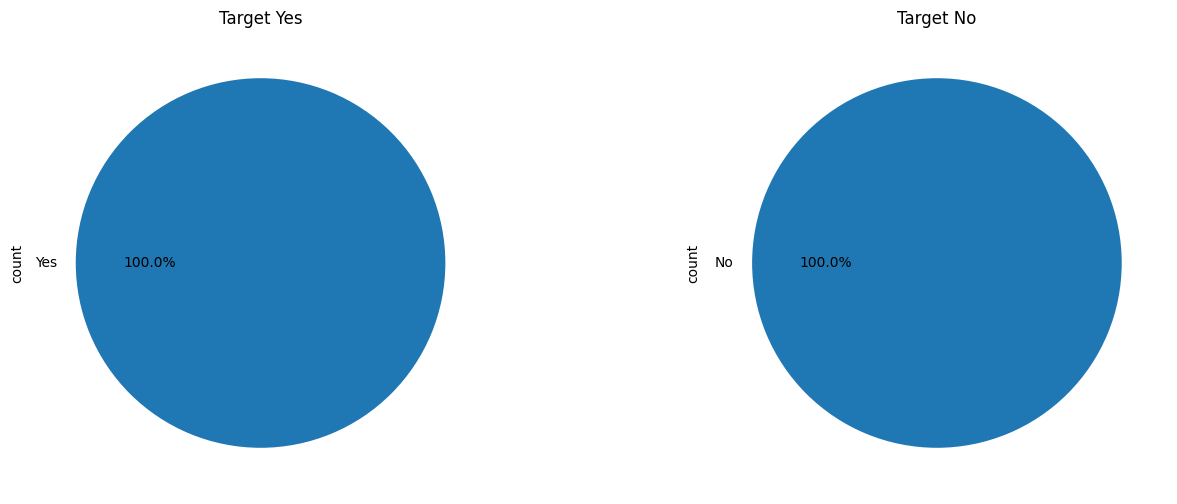

gender


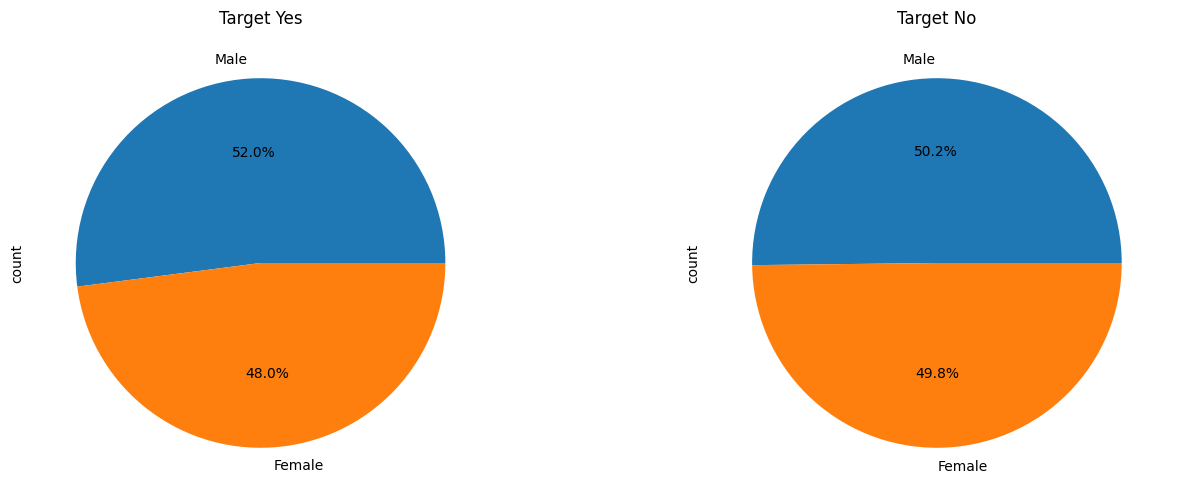

SeniorCitizen


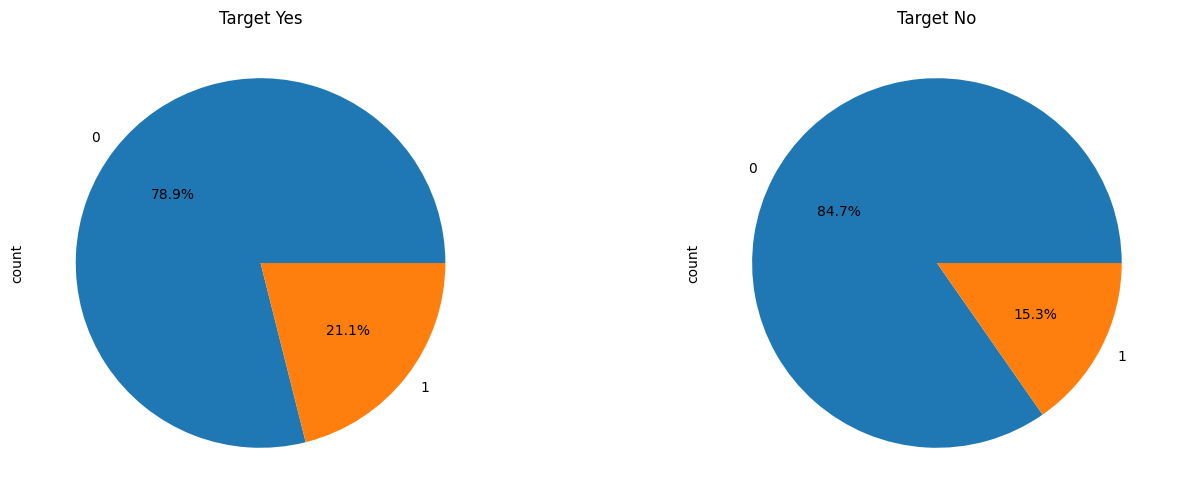

Partner


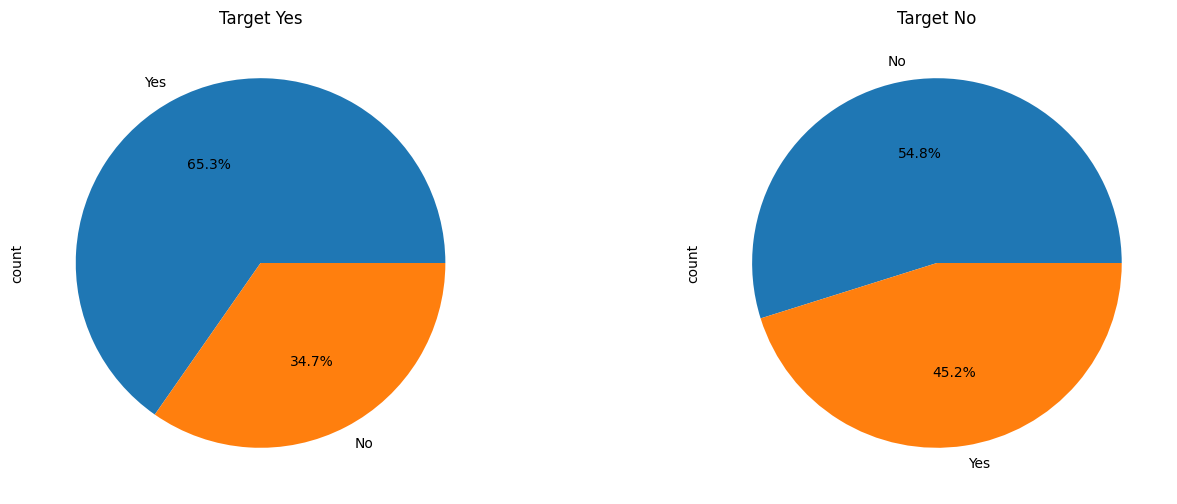

Dependents


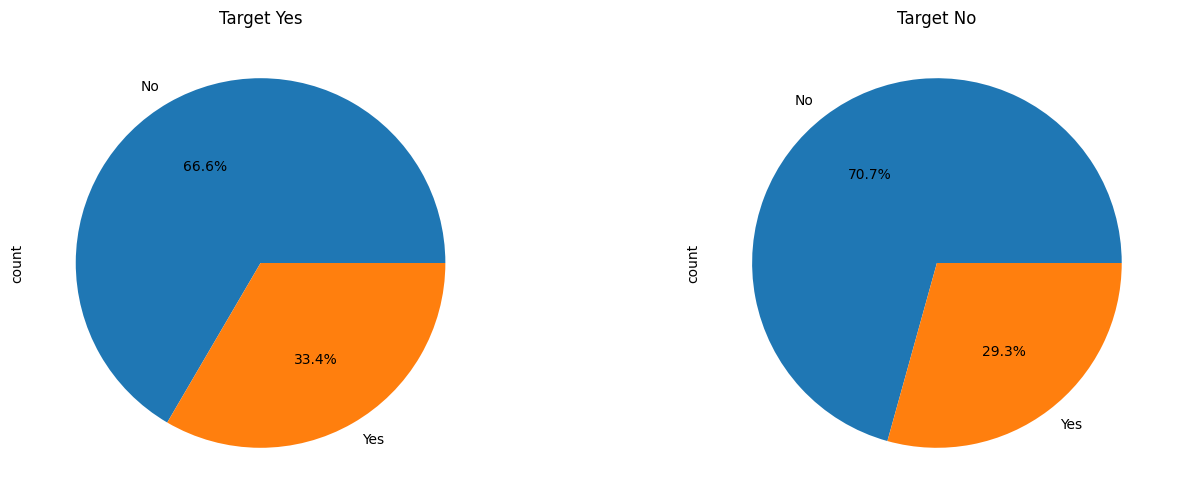

InternetService


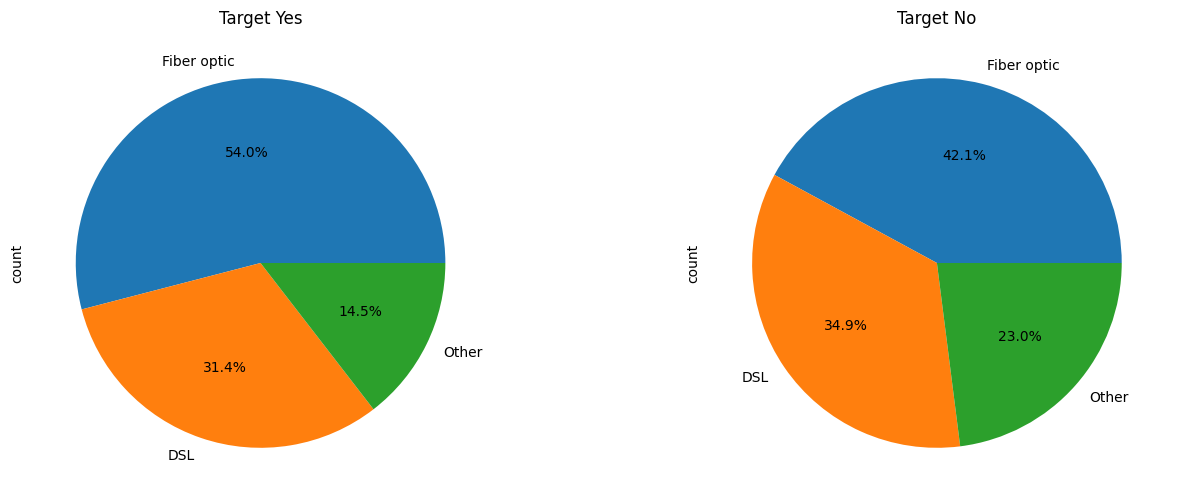

OnlineSecurity


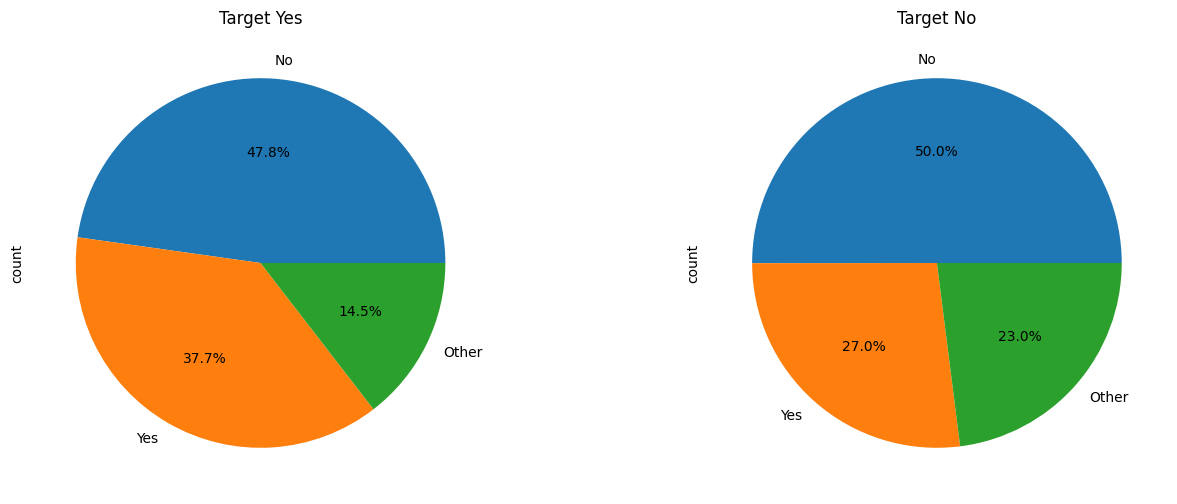

OnlineBackup


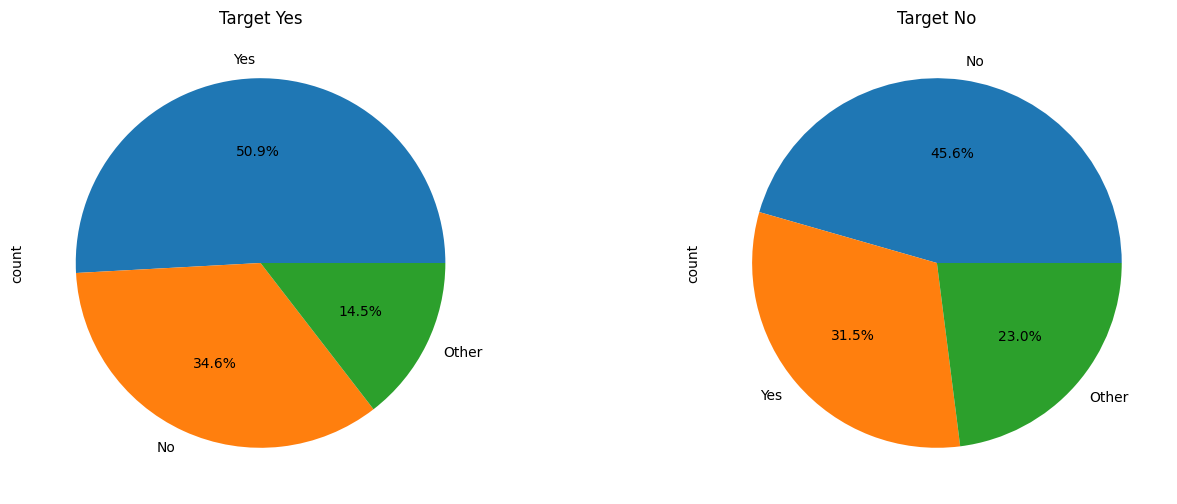

DeviceProtection


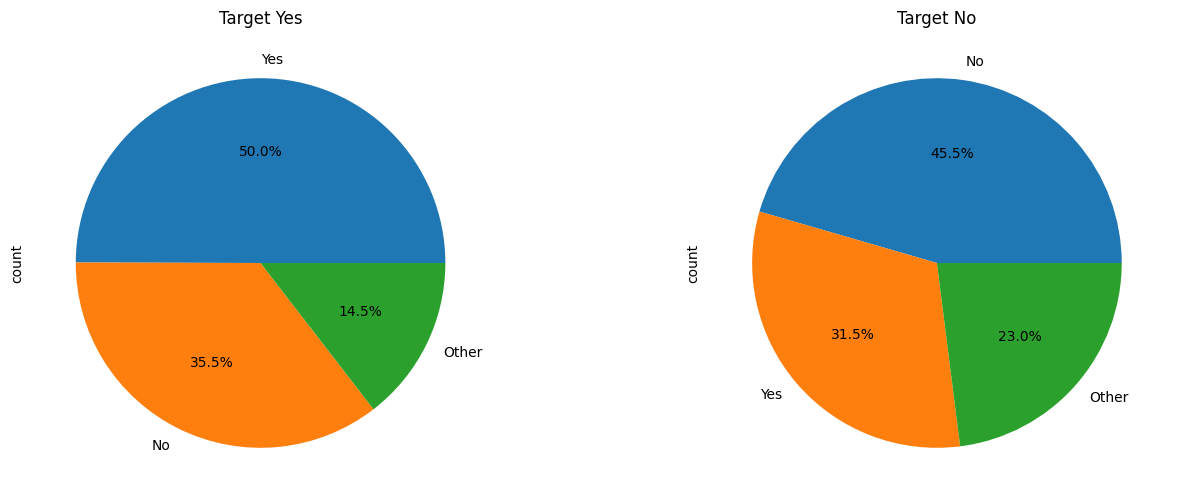

TechSupport


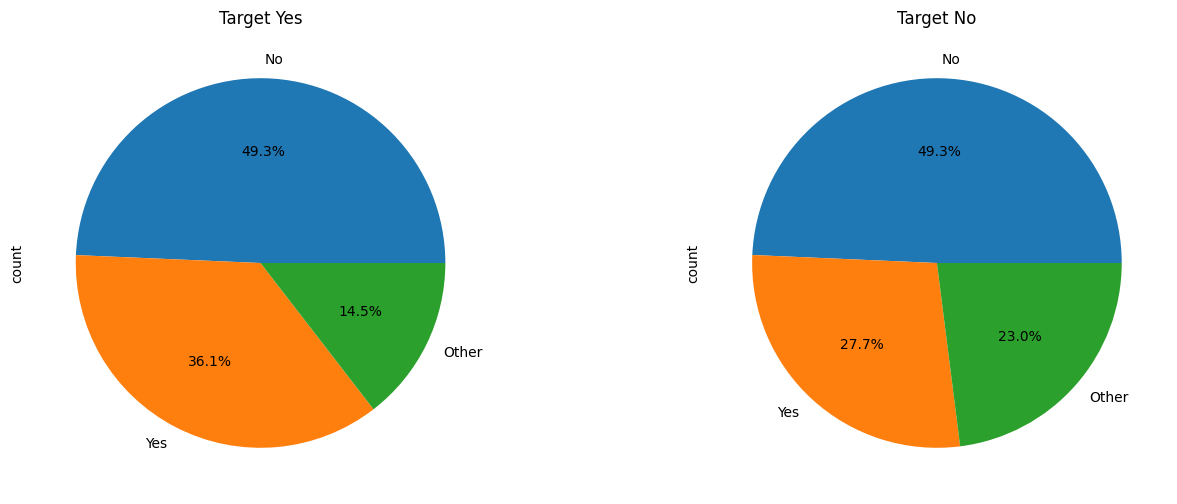

StreamingTV


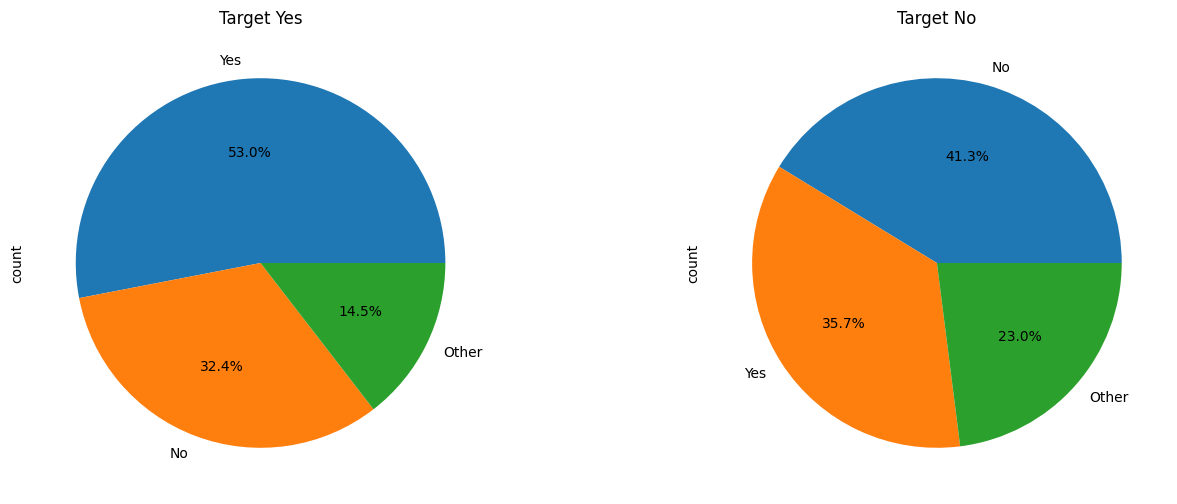

StreamingMovies


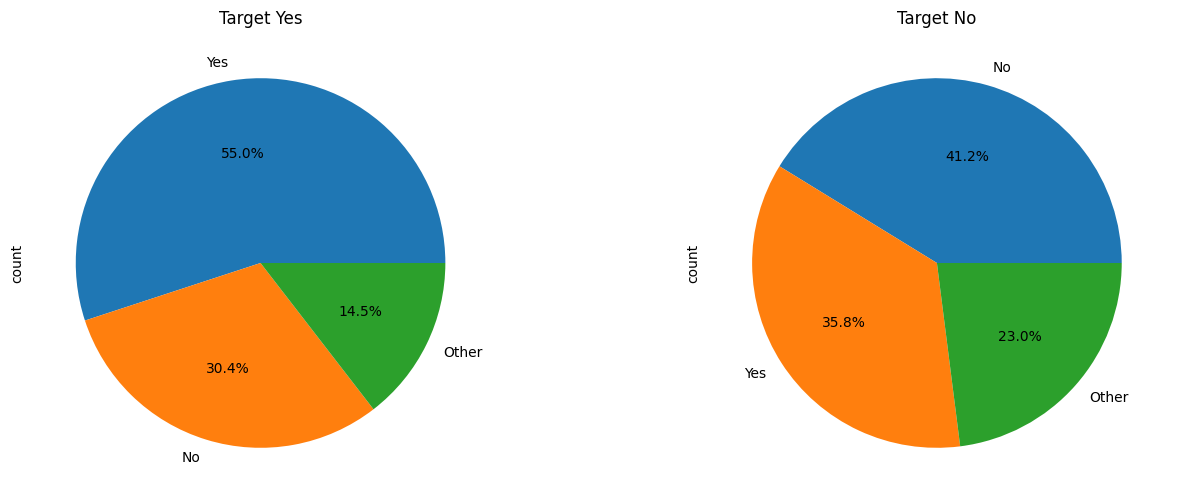

MultipleLines


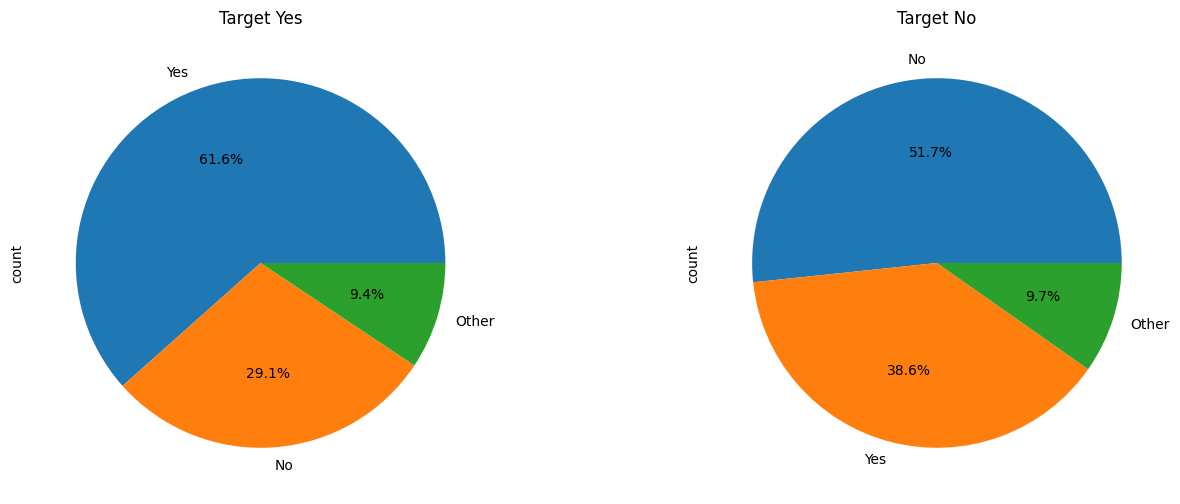

In [33]:
# Визуализируем object данные c разбивкой по Target 
for column in data_object_columns:
    print(column)
    plt.figure(figsize=(16, 6))  
    plt.subplot(1, 2, 1)
    pie_plotter_pair(data[data['Target'] == 'Yes'][column])
    plt.title('Target Yes')
    plt.subplot(1, 2, 2)
    pie_plotter_pair(data[data['Target'] == 'No'][column])
    plt.title('Target No')
    plt.show()

Target Yes

MonthlyCharges


count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: MonthlyCharges, dtype: float64

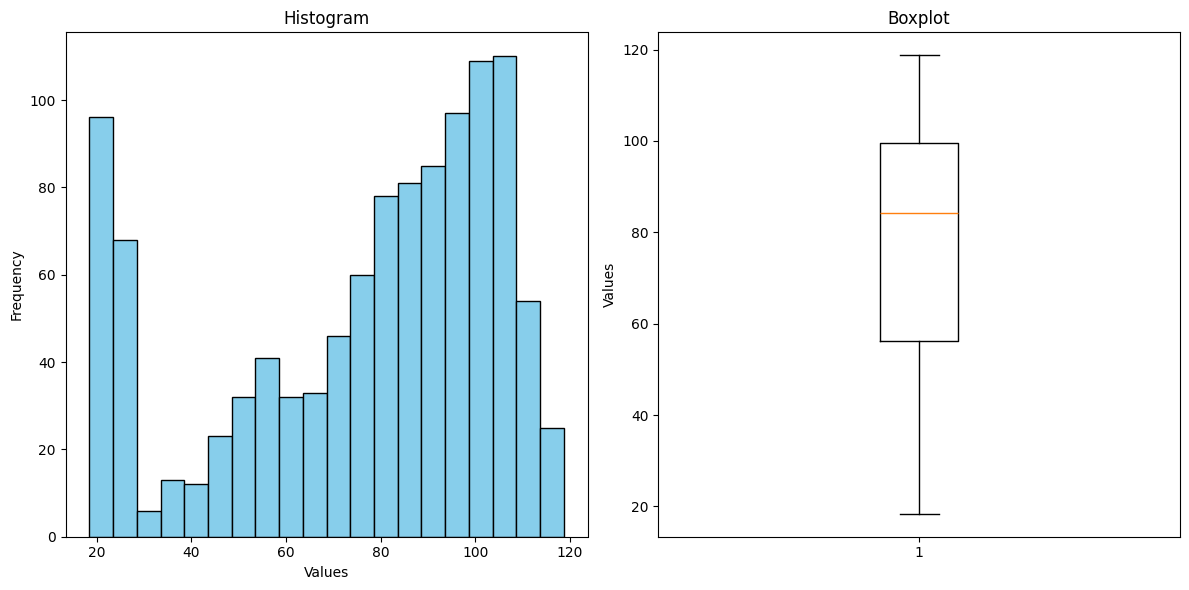

Target No

MonthlyCharges


count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: MonthlyCharges, dtype: float64

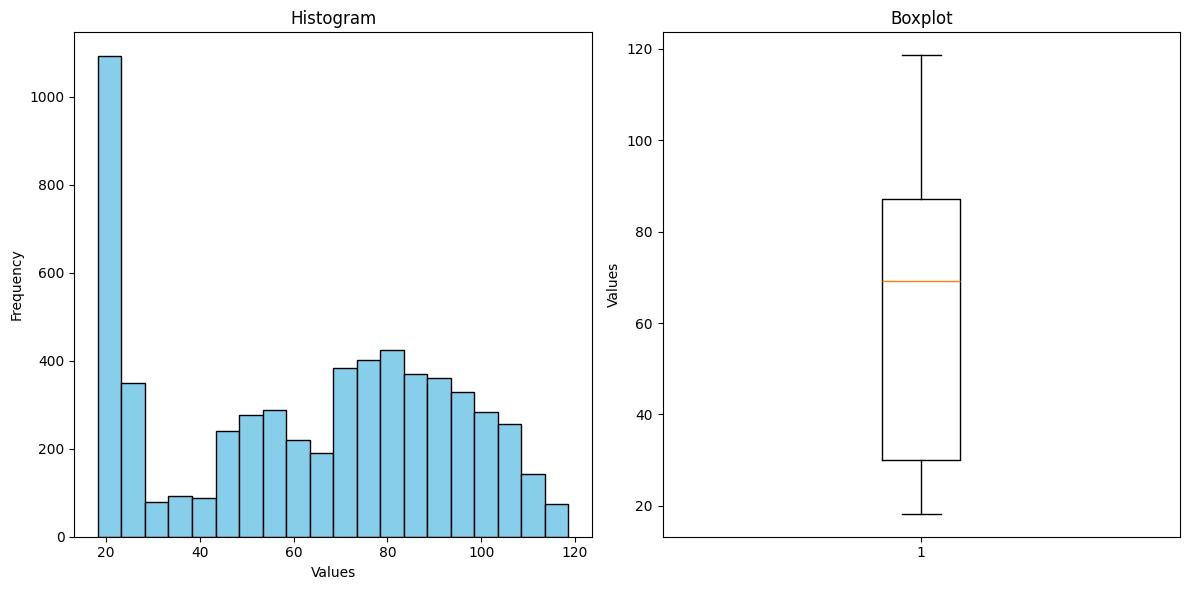

Target Yes

TotalCharges


count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: TotalCharges, dtype: float64

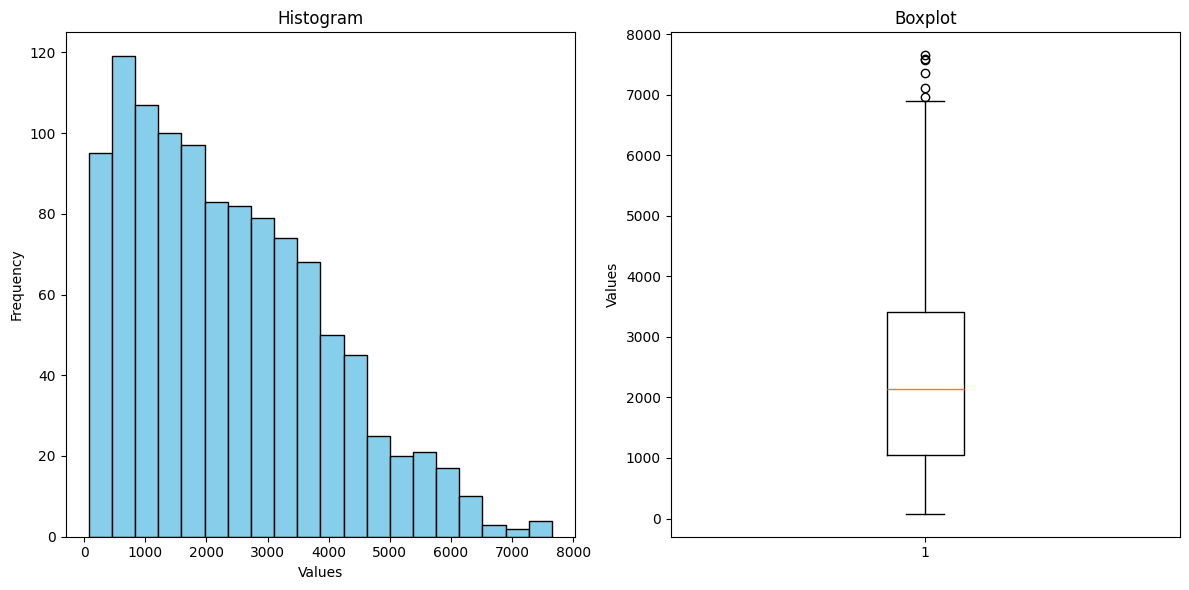

Target No

TotalCharges


count    5942.000000
mean     2067.866420
std      2193.898483
min         0.000000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: TotalCharges, dtype: float64

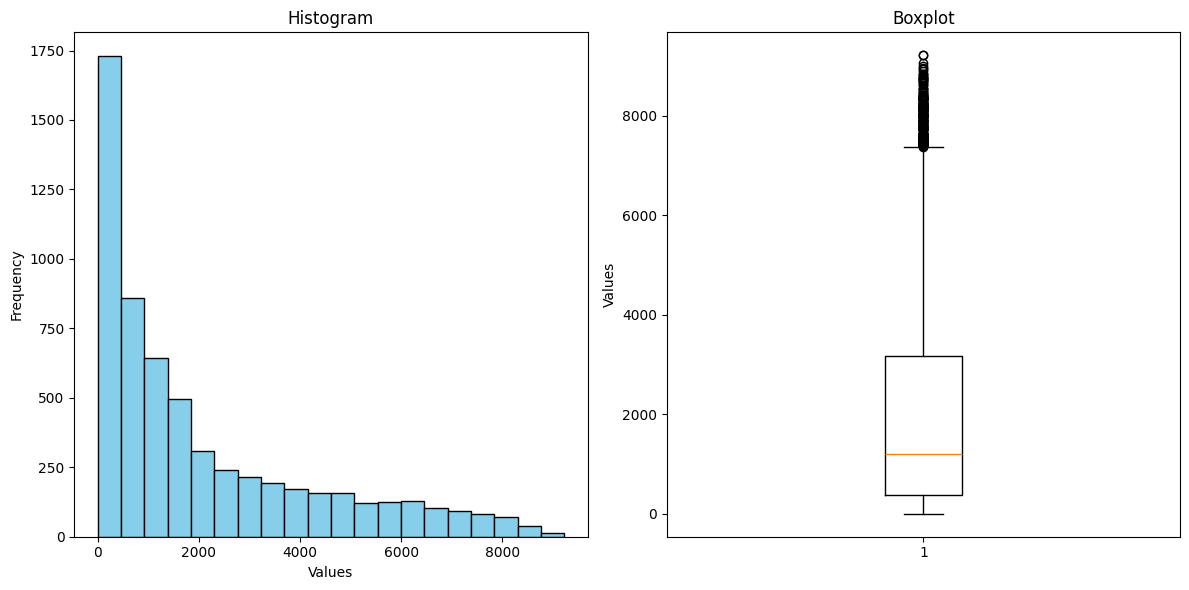

Target Yes

Duration


count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: Duration, dtype: float64

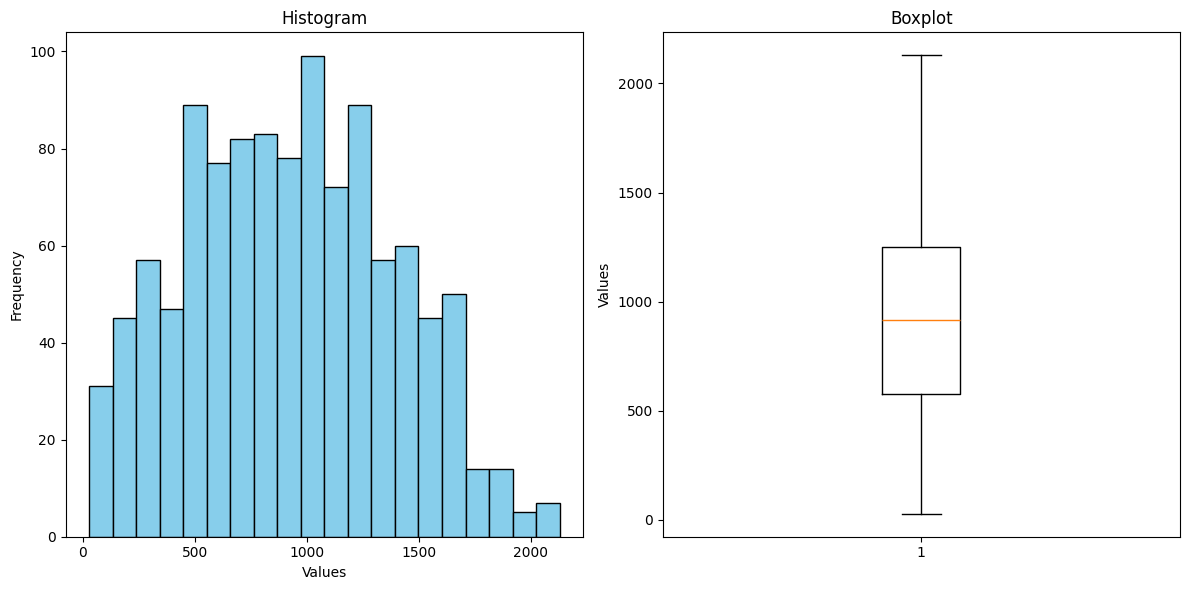

Target No

Duration


count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: Duration, dtype: float64

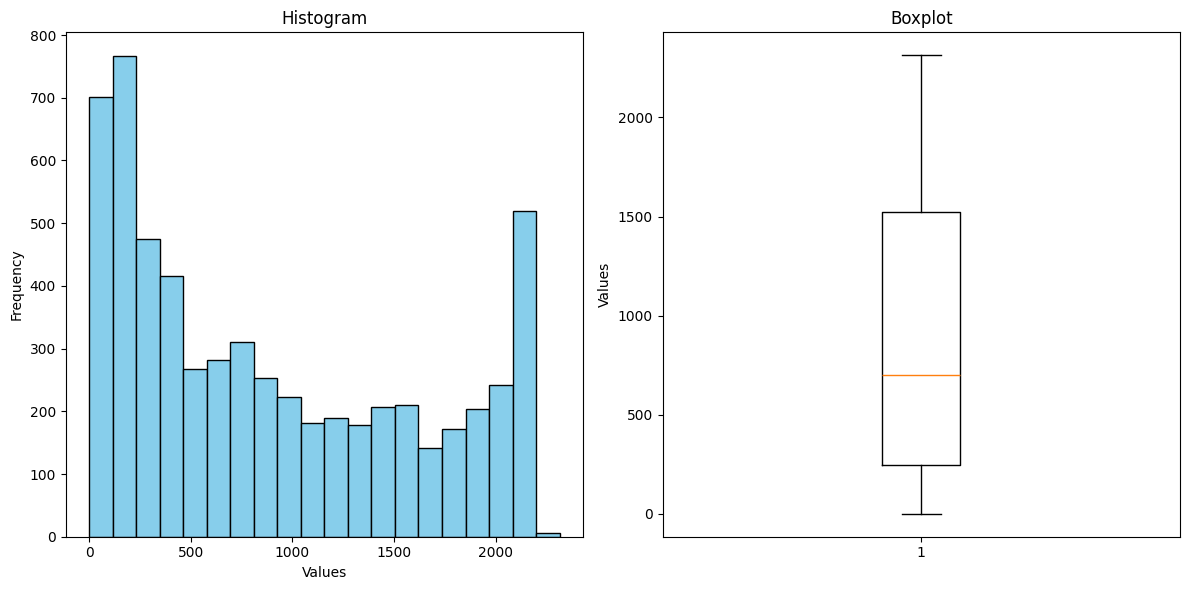

In [34]:
# Визуализируем float данные c разбивкой по Target 
for column in data_numeric_columns:
    print('Target Yes')
    hist_plotter(data[data['Target'] == 'Yes'][column])
    print('Target No')
    hist_plotter(data[data['Target'] == 'No'][column])

Разбивка по Target позволила выявить некоторые различия между портертом уходящего клиента и портретом текущего клиента. Так, например, TechSupport, Dependents и Gender очень схожи в обоих выборках. 

В то же время категориальные Type, PaymentMethod и численные MonthlyCharges, TotalCharges и Duration демонстрируют большую разницу. Изучение гистограмм столбца Duration c разбивкой по Target позволяет сказать, что первый пик с короткой длительностью пользования говорит о большом количестве новых клиентов, т.к. они имеют Target No, т.е. являются текущими клиентами.

### Корреляционный анализ

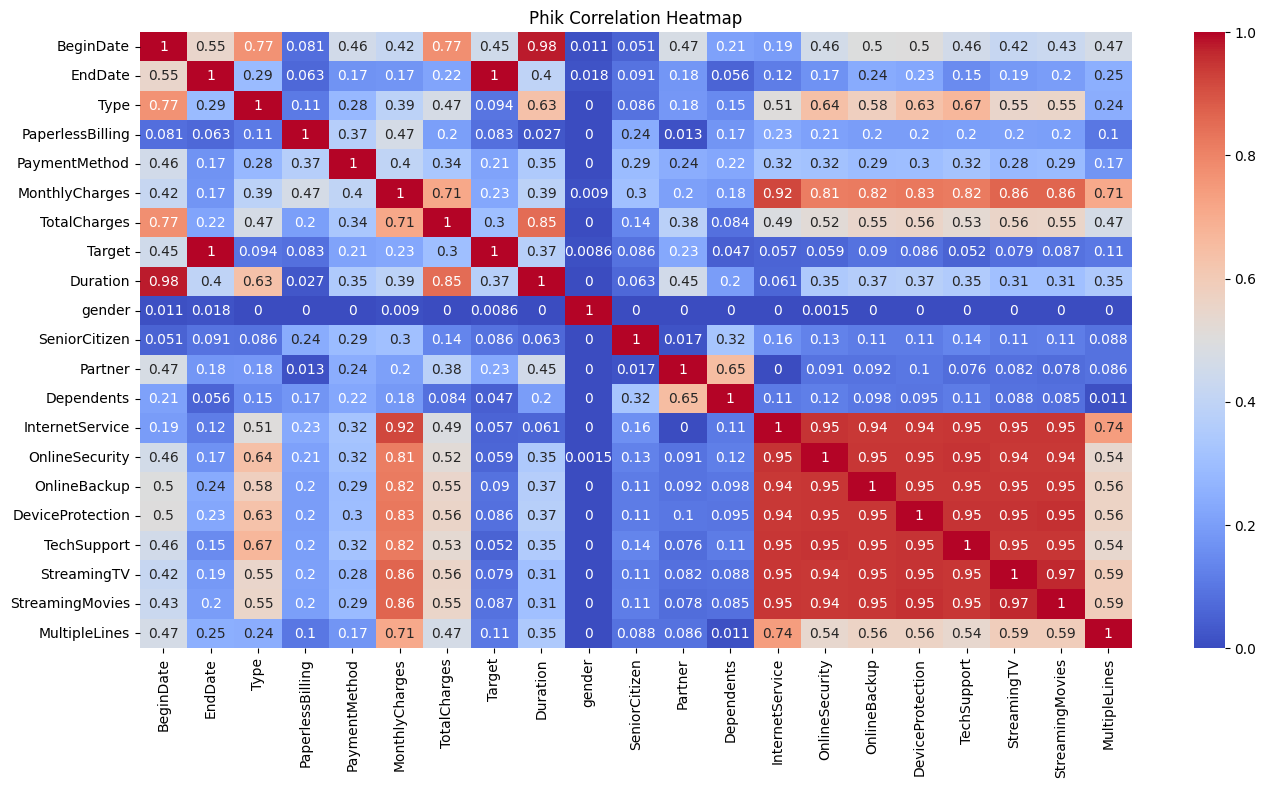

In [35]:
# Построим таблицу с к-тами корреляции при помощи phik
plt.figure(figsize=(16, 8))
phik_corr = data.phik_matrix(interval_cols = ['TotalCharges', 'MonthlyCharges', 'Duration'])
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Heatmap')
plt.show()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Target,Duration,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,
9822-OAOVB,Month-to-month,Yes,Electronic check,55.45,No,31.0,0,No,No,No
7733-UDMTP,Month-to-month,Yes,Electronic check,55.00,No,1737.0,1,No,No,Other
0877-SDMBN,One year,Yes,Bank transfer (automatic),103.95,Yes,1310.0,0,No,No,Yes
4059-IIEBK,Month-to-month,Yes,Bank transfer (automatic),78.55,No,215.0,0,No,No,Yes
7954-MLBUN,Two year,No,Bank transfer (automatic),99.45,No,945.0,0,No,No,No


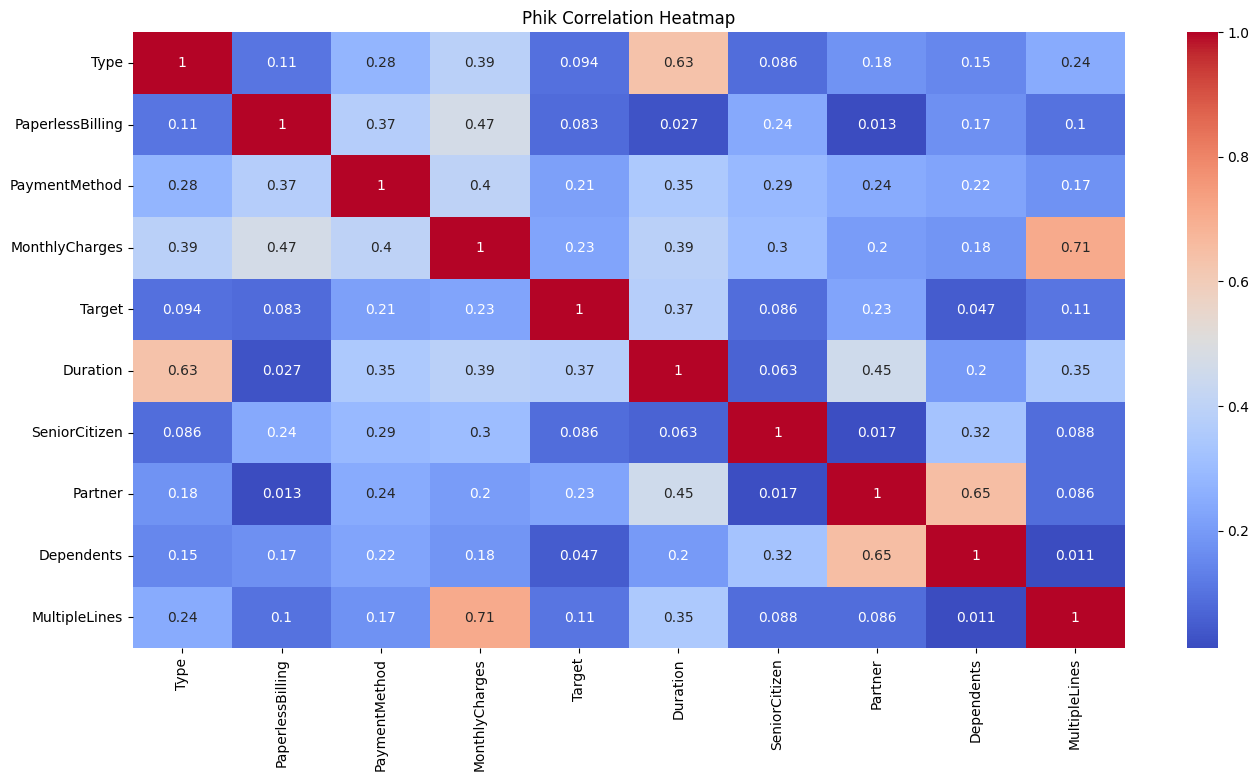

In [36]:
# Удаляем столбцы для устранения неинформативных, мультиколлинеарнных данных и предотвращения утечки
data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'gender', 
                  'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                  'TechSupport', 'StreamingTV', 'StreamingMovies'], axis = 1)

display(data.sample(5))

# Построим обновленную таблицу с к-тами корреляции при помощи phik
plt.figure(figsize=(16, 8))
phik_corr = data.phik_matrix(interval_cols = ['Duration', 'MonthlyCharges']) 
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Heatmap')
plt.show()

В ходе корреляционного анализа были выявлены 
- логичные утечки данных в целевой признак (EndDate), 
- мультиколлинеарность (Duration и BeginDate, InternetService, StreamingMovies, StreamingTV, OnlineSecurity, OnlineBackup, TechSupport, DeviceProtection и MonthlyCharges, TotalCharges и Duration),
- малоинформативные признаки, отчасти совпадающие с анализом распределений (gender).

Итоговый датасет и его матрица корреляции не имеют этих проблем. 

## Построение моделей

### Cоздание Pipeline и обучение моделей

In [37]:
# Разделим фичи и целевой признак
X = data.drop(columns=['Target'])
y = data['Target']

# Создадим тестовую и тренировочную выборки, применим стратификацию по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=220424, stratify=y)

In [38]:
# Разделим фичи на численные и категориальные
numeric_features = X.select_dtypes(include=['float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Создадим пайплайн предобработки численных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [39]:
# Создадим предобработчик данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создадим пайплайн для СatBoostСlassifier модели
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=220424, verbose = False))  
])

# Создадим сетку гиперпараметров для CatBoostClassifier модели
catboost_param_grid = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__depth': [4, 8],
    'classifier__iterations': [100, 300],
    'classifier__l2_leaf_reg' : [0.5, 2]
}

# Создадим пайплайн для RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=220424, verbose = 0)) 
])

# Создадим сетку гиперпараметров для RandomForestClassifier модели
rf_param_grid = {
    'classifier__n_estimators': [200, 500],
    'classifier__max_depth': [4, 8],
    'classifier__min_samples_split': [3, 10]
}

In [40]:
# С помощью кросс-валидации выберем лучшие по AUC-ROC метрике гиперпараметры для CatBoostClassifier модели 
catboost_grid = GridSearchCV(catboost_pipeline, param_grid=catboost_param_grid, scoring='roc_auc', cv=5)
catboost_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'Duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x164b86660>)]),
             param_grid={'classifier__depth': [4, 8],
                         'classifier__iterations': [100, 300],
                         'classifier__l2_leaf_reg': [0.5, 2],
                         'classifier__learning_rate': [0.05, 0.1]},
             scoring='roc_auc')

In [41]:
# Выведем лучшие гиперпараметры CatBoostClassifier модели и AUC-ROC метрику на кросс-валидации
print("CatBoost Best Hyperparameters:", catboost_grid.best_params_)
print("CatBoost Best AUC-ROC CV Score:", np.round(catboost_grid.best_score_, 2))

CatBoost Best Hyperparameters: {'classifier__depth': 4, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 0.5, 'classifier__learning_rate': 0.1}
CatBoost Best AUC-ROC CV Score: 0.92


In [42]:
# С помощью кросс-валидации выберем лучшие по AUC-ROC метрике гиперпараметры для RandomForestClassifier модели 
rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, scoring='roc_auc', cv=5)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'Duration']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=220424))]),
             param_grid={'classifier__max_depth': [4, 8],
                         'classifier__min_samples_split': [3, 10],
                         'classifier__n_estimators': [200, 500]},
             scoring='roc_auc')

In [43]:
# Выведем лучшие гиперпараметры RandomForestClassifier модели и AUC-ROC метрику на кросс-валидации
print("Random Forest Best Hyperparameters:", rf_grid.best_params_)
print("Random Forest Best AUC-ROC CV Score:", np.round(rf_grid.best_score_, 2))

Random Forest Best Hyperparameters: {'classifier__max_depth': 8, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 500}
Random Forest Best AUC-ROC CV Score: 0.83


Были построены пайплайны для двух классификационных моделей: RandomForest и CatBoost.

Созданы тестовая и тренировочная выборки. 

Модели были обучены при помощи кросс-валидации GridSearchCV и найдены наилучшие гиперпараметры для каждой из них.

CatBoostClassifier продемонстрировала лучшую метрику (0.92 против 0.83 у RandomForestClassifier) и превзошла требуемый порог (0.85). Далее будет произведена оценка работы модели на тестовой выборке. 





### Оценка метрик выбранной модели на тестовой выборке

CatBoost Test AUC-ROC: 0.92
CatBoost Test Accuracy: 0.92


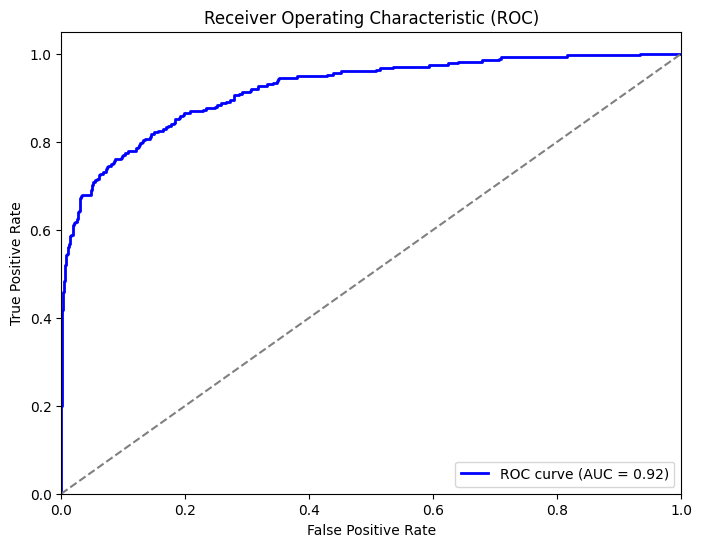

In [44]:
# Получаем предсказания CatBoostClassifier модели на тестовой выборке
catboost_probs = catboost_grid.predict_proba(X_test)[:, 1]  
catboost_preds = catboost_grid.predict(X_test)  

# Рассчитываем AUC-ROC и Accuracy метрику для CatBoostClassifier модели на тестовой выборке
catboost_auc_roc = roc_auc_score(y_test, catboost_probs)
catboost_accuracy = accuracy_score(y_test, catboost_preds)

# Выводим AUC-ROC и Accuracy метрику
print("CatBoost Test AUC-ROC:", np.round(catboost_auc_roc, 2))
print("CatBoost Test Accuracy:", np.round(catboost_accuracy, 2))

# Построим также Receiver Operating Characteristic
y_test_num = y_test.map({'Yes': 1, 'No': 0})
fpr, tpr, _ = roc_curve(y_test_num, catboost_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show();

Выбранная модель CatBoostClassifier продемонстрировала хорошие значения метрик AUC-ROC 0.92 и Accuracy 0.92 на тестовой выборке.

Высокое значение метрики Accuracy говорит о том, что модель очень хорошо в среднем классифицирует клиентов (прогнозирует их уход), однако, наш кейс имеет существенный дисбаланс классов (84% против 16%) и не стоит полагаться только на метрику Accuracy. Так, например, на большой выборке можно было бы без модели добиться Accuracy 0.84, просто константно прогнозируя, что клиент останется.

### Анализ важности фичей

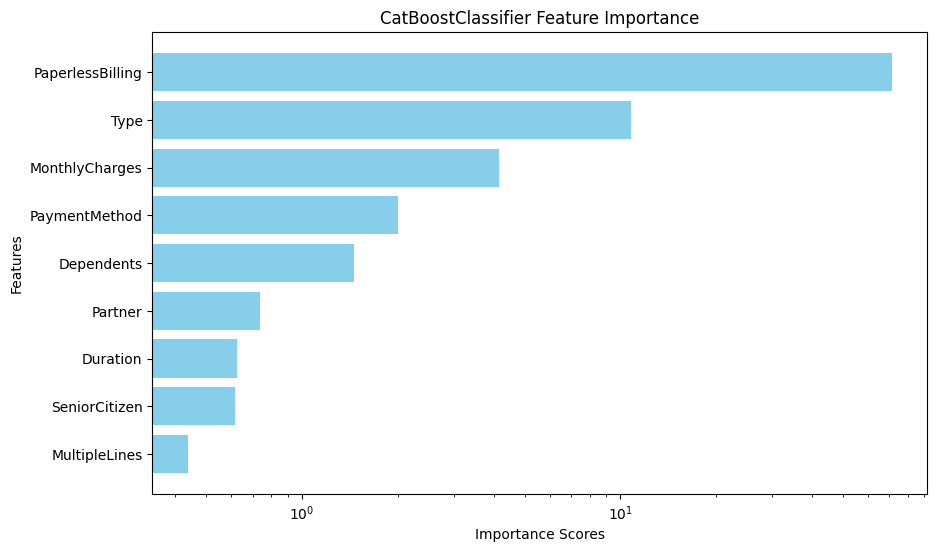

In [45]:
# Построим график важности фичей для CatBoostClassifier модели
best_pipeline = catboost_grid.best_estimator_
best_catboost_model = best_pipeline.named_steps['classifier']
feature_importance = best_catboost_model.feature_importances_

# Скомбинируем названия и важность фичей
feature_names = list(X.columns)  
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Отсортируем фичи по важности
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Выведем важность фичей
sorted_feature_names = list(sorted_feature_importance.keys())
sorted_importance_scores = list(sorted_feature_importance.values())
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores, color='skyblue')
plt.xlabel('Importance Scores')
plt.ylabel('Features')
plt.title('CatBoostClassifier Feature Importance')
plt.xscale('log')
plt.gca().invert_yaxis()  
plt.show()


Распределение важности признаков в целом адекватно и отчасти коррелирует с проведенными исследовательским и/или корреляционными анализами. Наибольшее значение для нашей модели имеют значения признаков Type и PaperlessBilling, наименьшее значение - MultipleLines и SeniorCitizen.


### Матрица ошибок

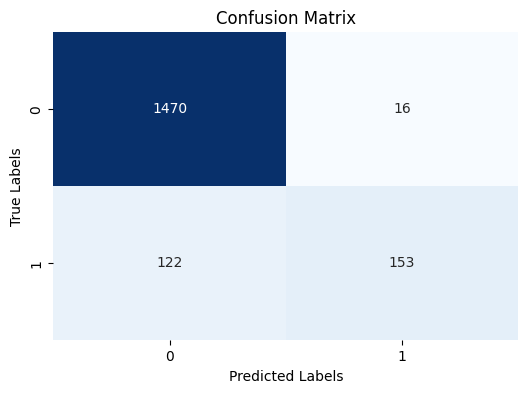

Accuracy: 0.92
Precision: 0.91
Recall: 0.56
F1-score: 0.69


In [46]:
# Построим матрицу ошибок CatBoostClassifier модели
conf_matrix = confusion_matrix(y_test, catboost_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Вычисление метрик
accuracy = accuracy_score(y_test, catboost_preds)
precision = precision_score(y_test, catboost_preds, pos_label='Yes')
recall = recall_score(y_test, catboost_preds, pos_label='Yes')
f1 = f1_score(y_test, catboost_preds, pos_label='Yes')

print("Accuracy:", np.round(accuracy, 2))
print("Precision:", np.round(precision, 2))
print("Recall:", np.round(recall, 2))
print("F1-score:", np.round(f1, 2))

Модель с высокой точностью предсказывает текущих клиентов (большое число TrueNegative и малое число FalseNegative).

Для предсказания уходящих клиентов модель работает значительно хуже (большое число TruePositive и значимое число FalsePositive). 

Это может быть обусловлено дисбалансом классов (текущих и уходящих клиентов) в обучающей выборке.

Тем не менее, модель имеет высокие значения метрик Accuracy и AUC-ROC, что требуется заказчику в данном кейсе. 

Также для справки дополнительно приведены метрики Precision, Recall и F1-Score.

## Выводы

Были изучены предоставленные заказчиком датасеты, проведена предобработка, исследовательский и корреляционный анализы, подготовка и создание итогового датасета. 

В ходе анализа и подготовки были созданы новые и удалены существующие входные признаки и целевой признак. 

Было постоено 2 пайплайна для подготовки данных и обучения 2 моделей: СatBoostClassifier и RandomForestClassifier. 

В ходе обучения с поиском лучших гиперпараметров лучше проявила себя модель СatBoostClassifier и продемонстрировала метрику AUC-ROС на кроссвалидации 0.92, что лучше метрики AUC-ROC 0.83 альтернативной модели и выше требуемого порога 0.85. 

Изучение важности входных признаков подтвердило адекватность модели. 

На тестовой выборке СatBoostClassifier продемонстрировала метрики AUC-ROC 0.92 и Accuracy 0.92, что удовлетворяет требованиям заказчика. 

Анализ матрицы рассеяния продемонстрировал логичное поведение модели, обученной на датасете с дисбалансом классов, модель демонстрирует достаточные значения метрик. 

Можно дать следующую рекомендацию бизнесу: 
1. Анализ способов платежей и длительности контракта показал, что месячные и автоматические платежи способствуют меньшему оттоку. Можно предположить, что такая зависимость возникает из-за меньших сумм, распределения платежа по месяцам и отсуствии необходимости совершать осознанный платеж в ручном режиме. 

2. Анализ длительности сотрудничества клиентов с компанией показал, что необходимо создавать лояльную клиентскую базу разными мотивационными программами, поскольку спустя длительное время пользования клиенты крайне редко отказываются от услуг.

3. Отдельно стоит изучить исключенные из модели признаки.